In [3]:
import signac
import numpy as np
import matplotlib.pyplot as plt
import cmeutils
from cmeutils.sampling import is_equilibrated, equil_sample
import matplotlib.cm as cm
import scienceplots
import gsd.hoomd
#plt.style.use('science')

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

color_dict = {
    (True, True): "k",
    (True, False): "b",
    (False, False): "g",
    (False, True): "orange",
}

In [4]:
project = signac.get_project("../pps-flow/")
done = [j.doc.done for j in project]
print("Done:", done.count(True), "Not Done:", done.count(False))

Done: 10 Not Done: 0


In [7]:
for job in project.find_jobs(doc_filter={"done": True}):
    try:
        red_vol = job.doc.average_vol
        red_vol_std = job.doc.vol_std
        
        vol_ang = job.doc.average_vol * (job.doc.ref_distance*job.doc.sigma_scale)**3
        vol_cm = vol_ang * (1e-8)**3
        vol_ang_std = red_vol_std * job.doc.ref_distance**3
        vol_cm_std = vol_ang_std * (1e-8)**3
        
        den = job.doc.total_mass / vol_cm
        den_std = job.doc.total_mass / vol_cm_std
        job.doc.average_density = den
        job.doc.density_std = den_std
        job.doc.sampled = True
    except Exception as e:
        print(e)        

'average_vol'


In [2]:
def mpa_from_reduced(reduced_pressure, sigma, epsilon):
    num = reduced_pressure * (epsilon*4184)
    denom = (6.022E23) * ((sigma*1e-10)**3)
    pressure_mpa = (num/denom) * 1e-6
    return pressure_mpa

In [30]:
for job in project.find_jobs(doc_filter={"done": True}):
    job.doc.pressure_mpa = mpa_from_reduced(
        reduced_pressure=job.doc.average_pressure,
        sigma=job.doc.ref_distance,
        epsilon=job.doc.ref_energy
    )

In [3]:
for job in project.find_jobs(doc_filter={"done": True}):
    try:
        job.doc.N
    except:
        with gsd.hoomd.open(job.fn("trajectory.gsd")) as traj:
            job.doc.N = traj[0].particles.N

/home/chrisjones4/miniconda3/envs/pps/lib/python3.9/site-packages/signac/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


Scale By: 1.0 New Sigma 3.6
0.001 1.1163497679730792
0.0027 1.151488428805031
0.005 1.1670273397659814
0.1 1.1517384199291
0.5 1.2081364994353463
1.0 1.2483987530143401
2.0 1.270067767499781
3.0 1.2942163516132459
4.0 1.298294890750163
5.0 1.3074838118399166
Scale By: 0.98 New Sigma 3.528
0.001 1.1861020577874435
0.0027 1.2234362689069087
0.005 1.23994608939088
0.1 1.2237018800936472
0.5 1.283623850856516
1.0 1.3264017894482105
2.0 1.3494247374603492
3.0 1.3750821847330257
4.0 1.3794155610652905
5.0 1.3891786286325392
Scale By: 0.97 New Sigma 3.492
0.001 1.2231651072981005
0.0027 1.2616659294238257
0.005 1.2786916450535748
0.1 1.2619398403690043
0.5 1.3237342393555482
1.0 1.3678488933214197
2.0 1.3915912572189395
3.0 1.4180504426155325
4.0 1.4225192273137948
5.0 1.4325873690137836
Scale By: 0.96 New Sigma 3.456
0.001 1.2617885651460767
0.0027 1.3015051142996685
0.005 1.3190684450118242
0.1 1.3017876744351988
0.5 1.365533333599341
1.0 1.4110409806025077
2.0 1.4355330488414413
3.0 1.4628

Text(0.5, 0, 'Pressure (Reduced)')

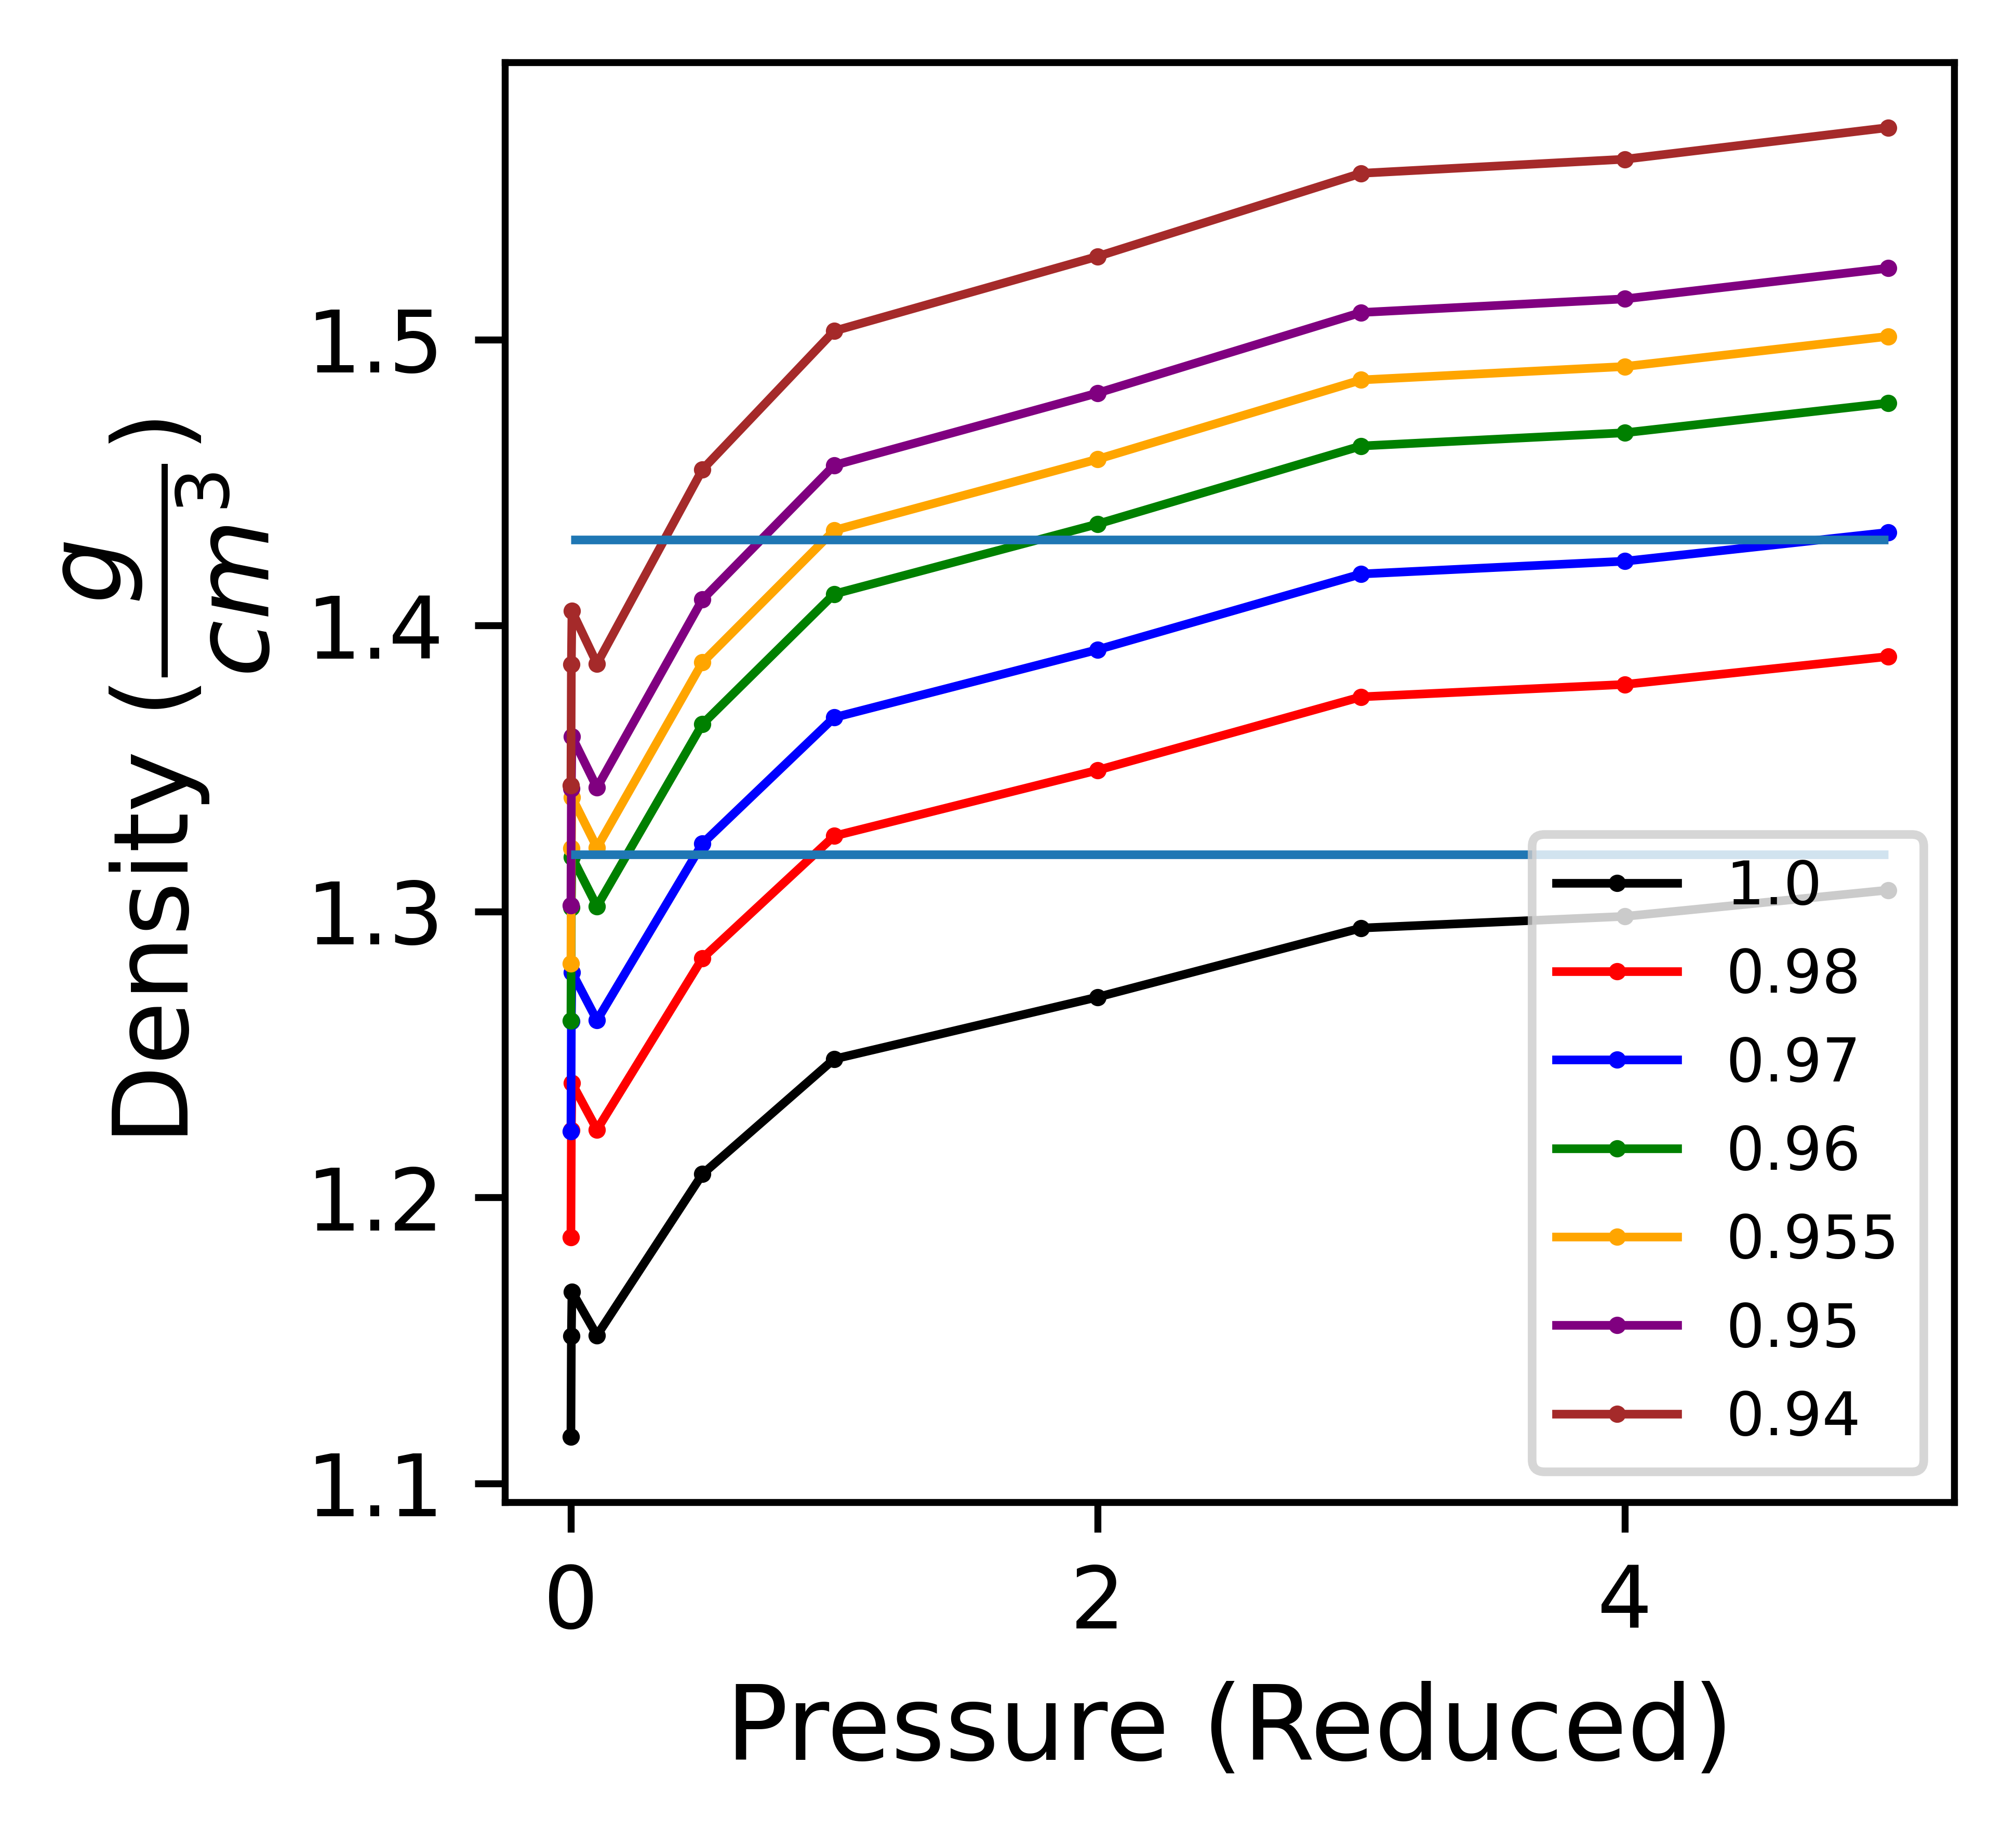

In [17]:
fig = plt.figure()
sigmas = [
    1.0,
    0.98,
    0.97,
    0.96,
    0.955,
    0.95,
    0.94
]
colors = ["k", "r", "blue", "green", "orange", "purple", "brown", "pink"]
for idx, sigma in enumerate(sigmas):
    print("Scale By:", sigma, "New Sigma", round(3.6*sigma, 3))
    pressures = []
    densities = []
    for P, job in project.find_jobs().groupby("pressure"):
        job = list(job)[0]
        red_vol = job.doc.average_vol
        red_vol_std = job.doc.vol_std 
        vol_ang = job.doc.average_vol * (job.doc.ref_distance*sigma)**3
        vol_cm = vol_ang * (1e-8)**3
        vol_ang_std = red_vol_std * job.doc.ref_distance**3
        vol_cm_std = vol_ang_std * (1e-8)**3
        den = job.doc.total_mass / vol_cm
        pressures.append(P)
        densities.append(den)
        print(P, den)
    plt.plot(pressures, densities, marker="o", c=colors[idx], label=sigma)
    print("============================")

plt.hlines(y=1.32, xmin=0, xmax=5)
#plt.vlines(x=1.35, ymin=0, ymax=5)
plt.hlines(y=1.43, xmin=0, xmax=5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("Density $(\dfrac{g}{cm^3})$")
plt.xlabel("Pressure (Reduced)")

678d271adef14158616ae070a4ff6066 1.316546681748768 0.015
c031bd6e67484b274b06683d06427341 1.3101380278030632 0.1
677e88e5851f33e1fe945e640b86b13e 1.3315976178992792 0.5
bc7fe2b0bc5f4c52587724bb273b4e6b 1.3457621528251689 1.0
daa6681d4aafb2c3d0e61d3721ae889a 1.3787155191304377 2.0
38a7c6e16540be76d9737dd60b883e02 1.4009067980197403 3.0
c8f68b6f46d1a1fec081ad797edcdc26 1.4399791128422763 4.0
b9df3299c1851bf98c965c1aa33bab9d 1.4827484390286052 5.0


Text(0, 0.5, 'Pressure (Reduced)')

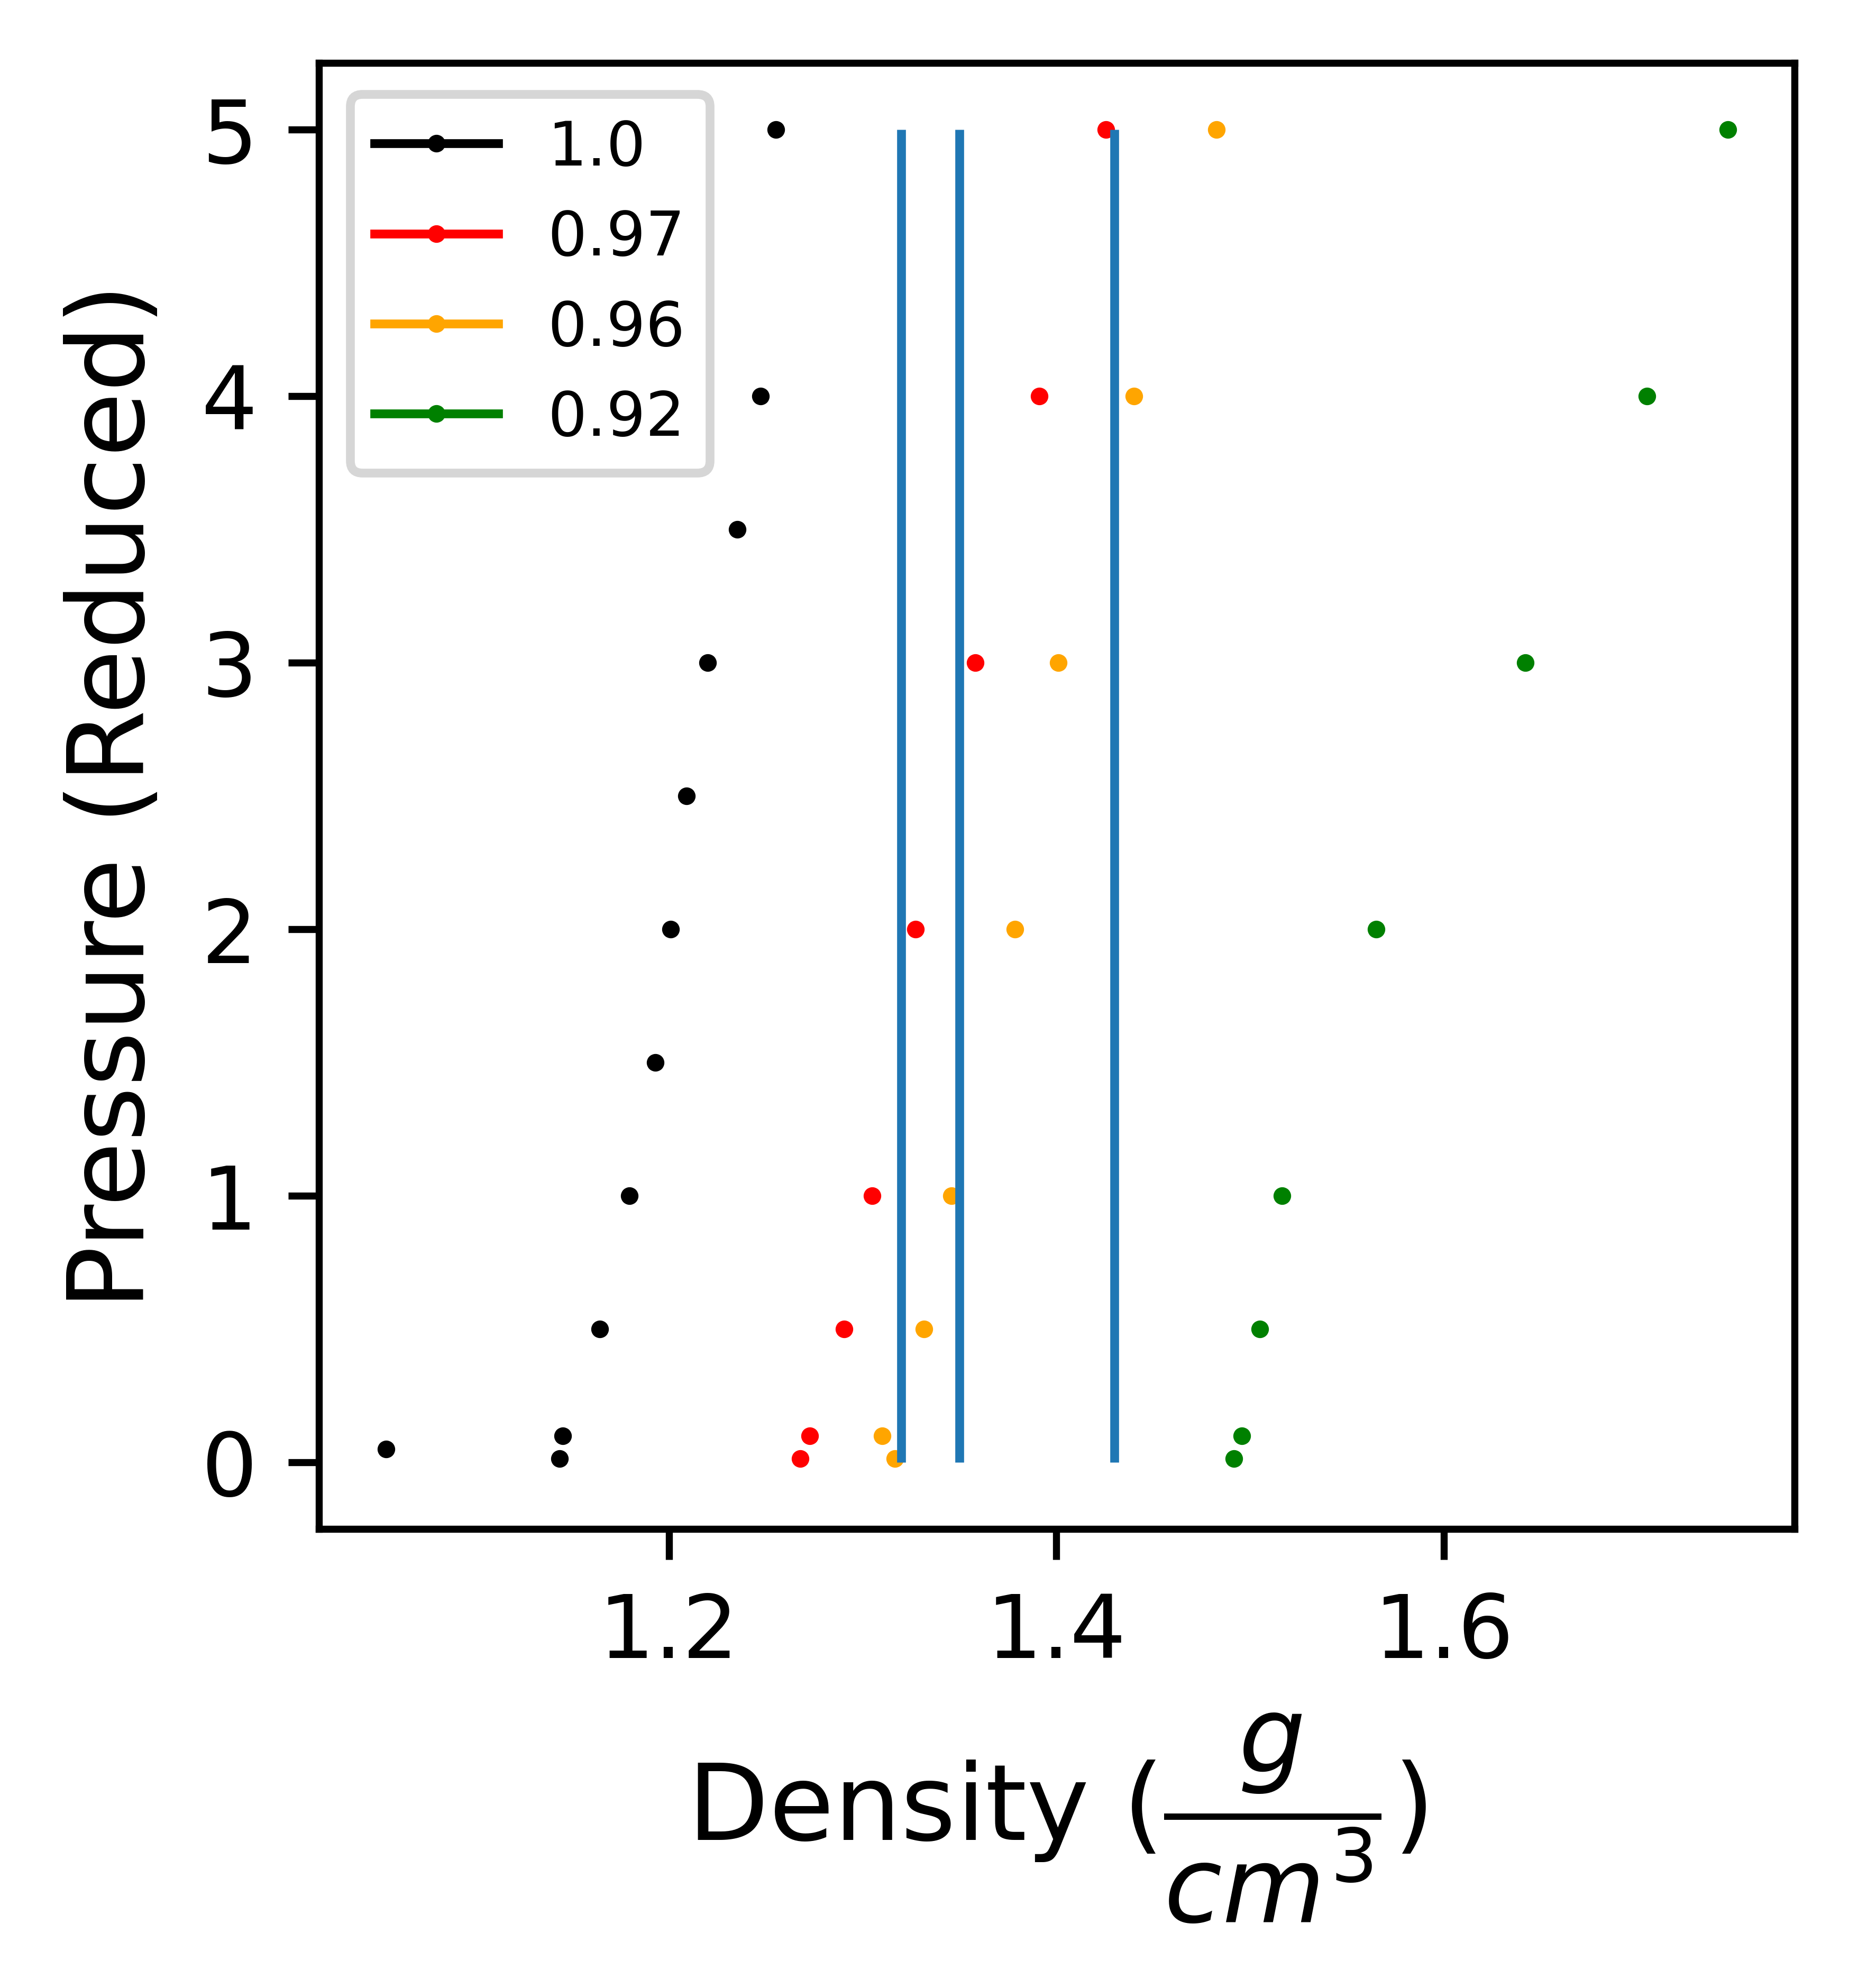

In [11]:
fig = plt.figure()
for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True, "sigma_scale": 1.0}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="k", label=job.doc.sigma_scale)


for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True, "sigma_scale": 0.97}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="r", label=job.doc.sigma_scale)


for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True, "sigma_scale": 0.96}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="orange", label=job.doc.sigma_scale)
    print(job, job.doc.average_density, P)



for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True, "sigma_scale": 0.92}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="g", label=job.doc.sigma_scale)
    
plt.vlines(x=1.32, ymin=0, ymax=5)
plt.vlines(x=1.35, ymin=0, ymax=5)
plt.vlines(x=1.43, ymin=0, ymax=5)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Density $(\dfrac{g}{cm^3})$")
plt.ylabel("Pressure (Reduced)")

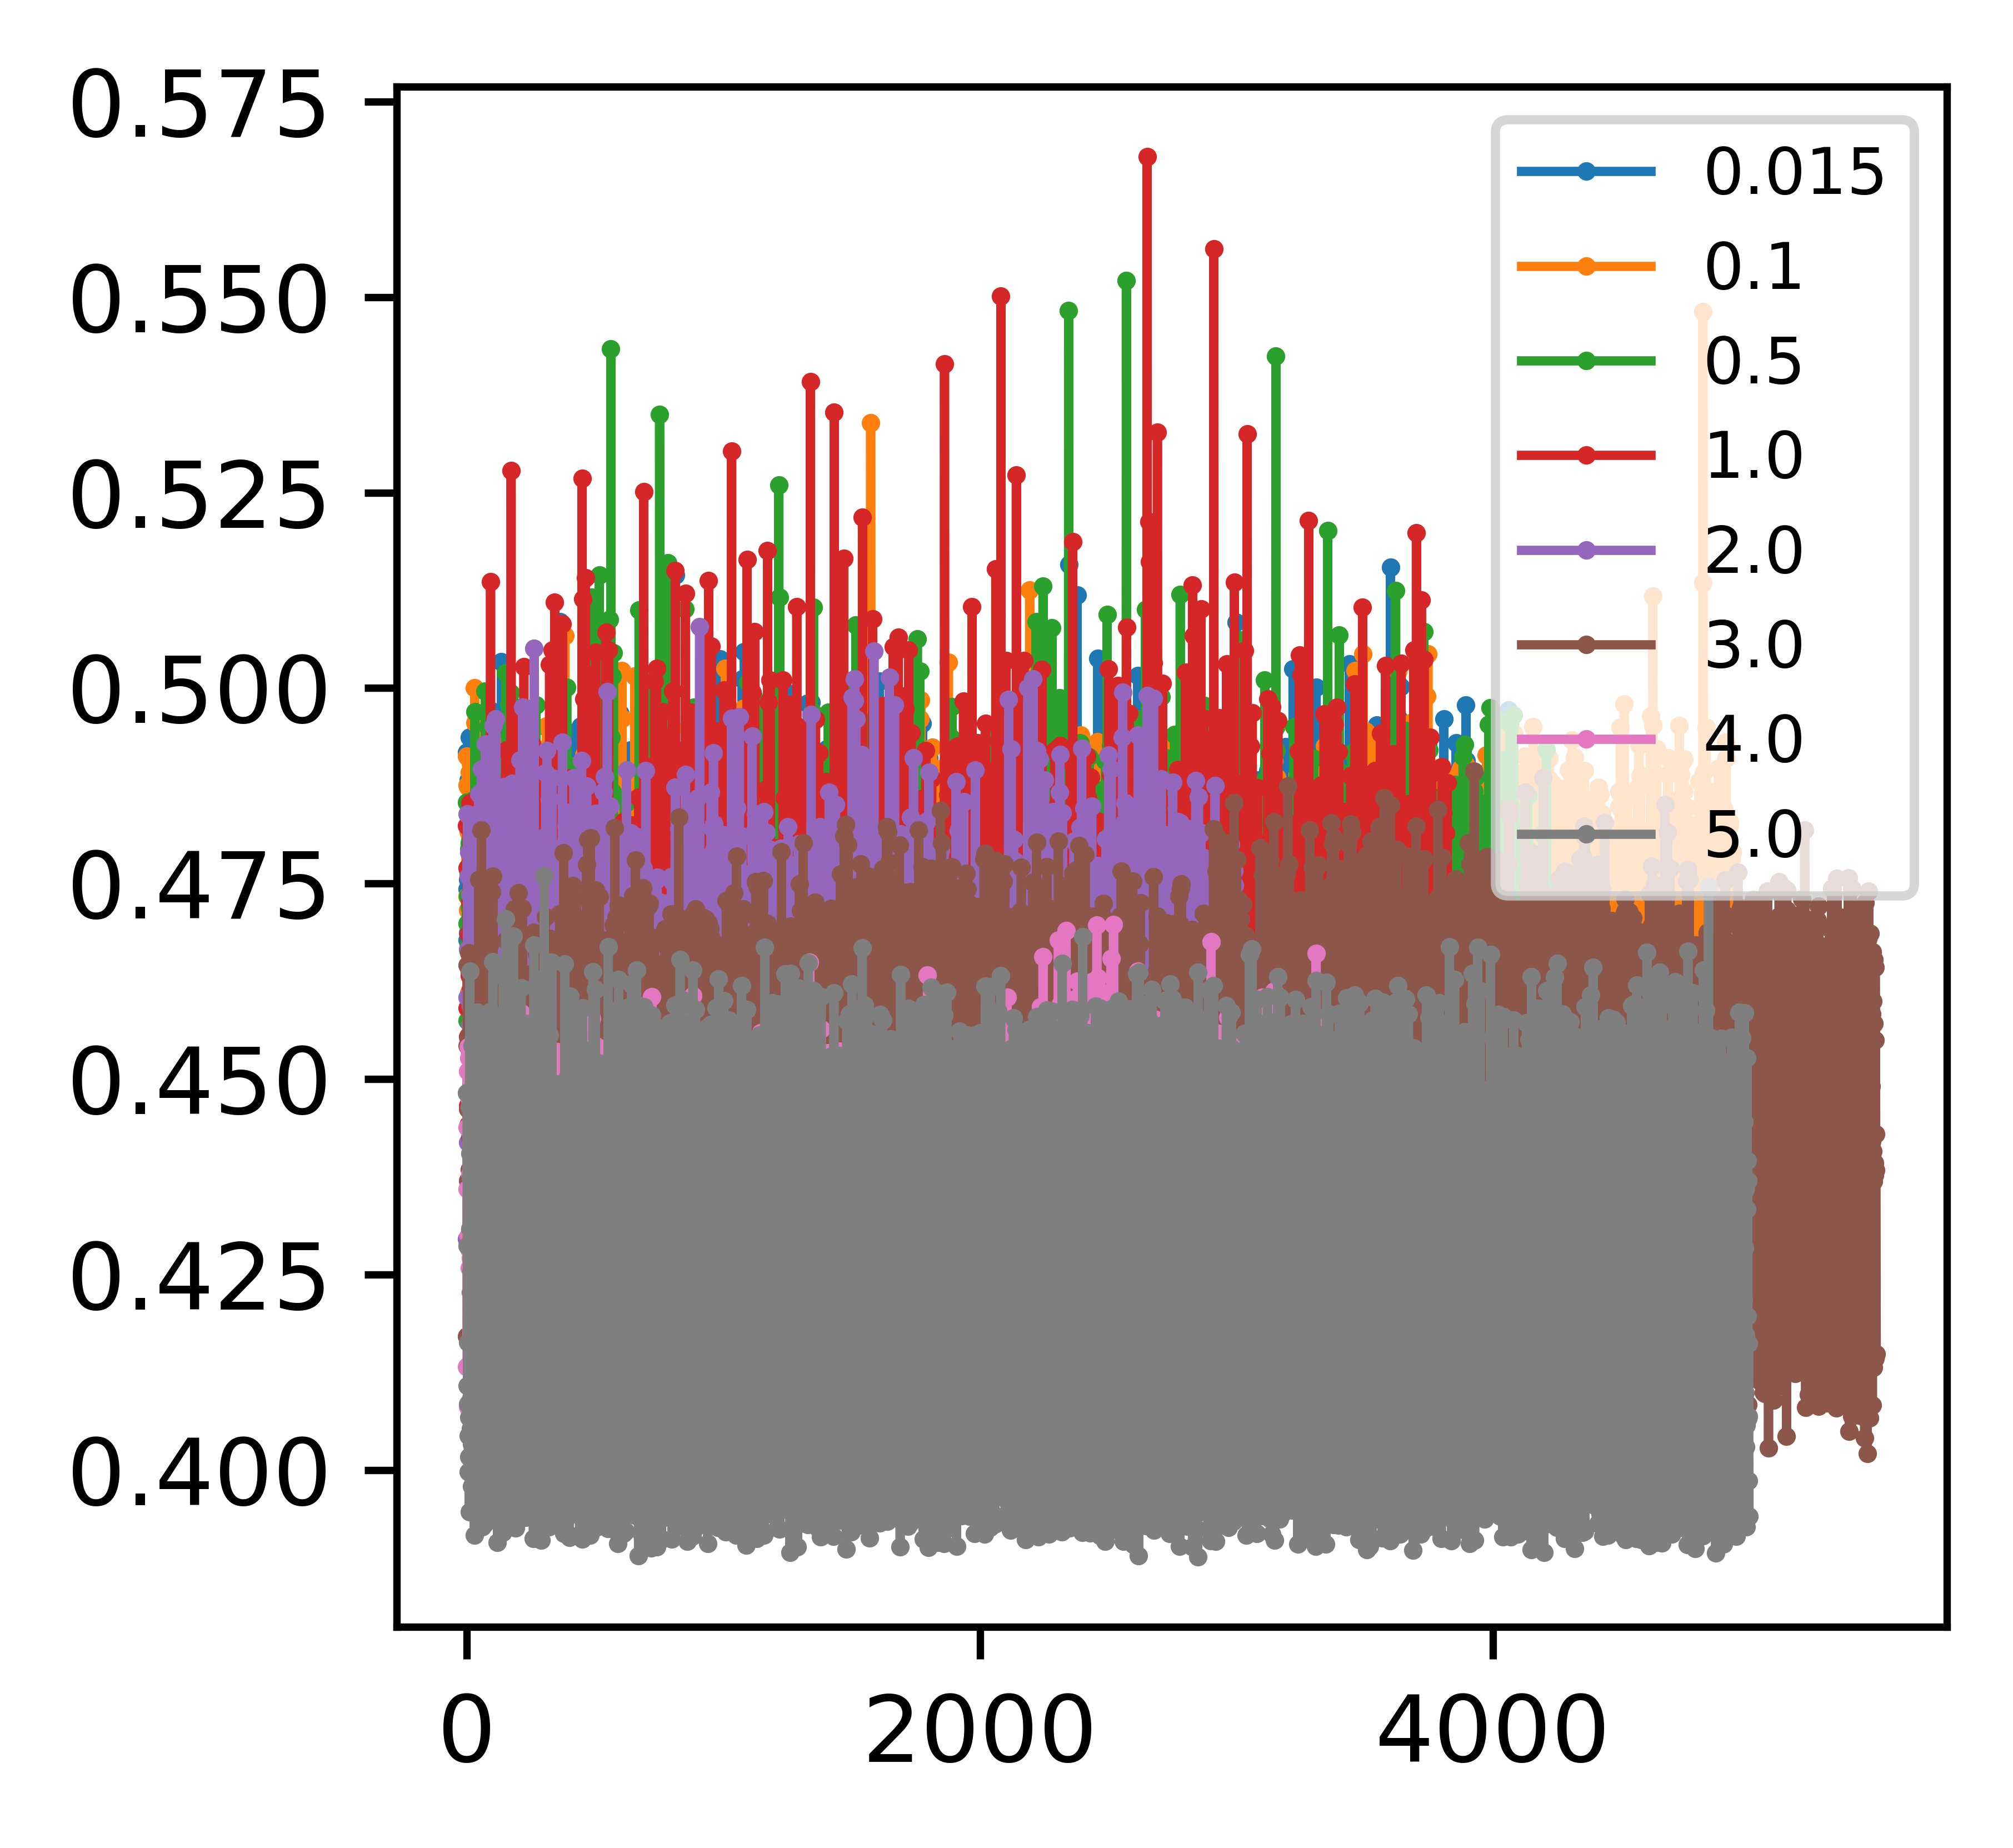

In [27]:
for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True, "sigma_scale": 0.97}).groupby("pressure"):
    job = list(job)[0]
    data = np.genfromtxt(job.fn("volume.txt"))
    plt.plot(data/job.doc.N, label=job.sp.pressure)
    
plt.legend()

# Pressure vs Density:

Text(0, 0.5, 'Pressure (Reduced)')

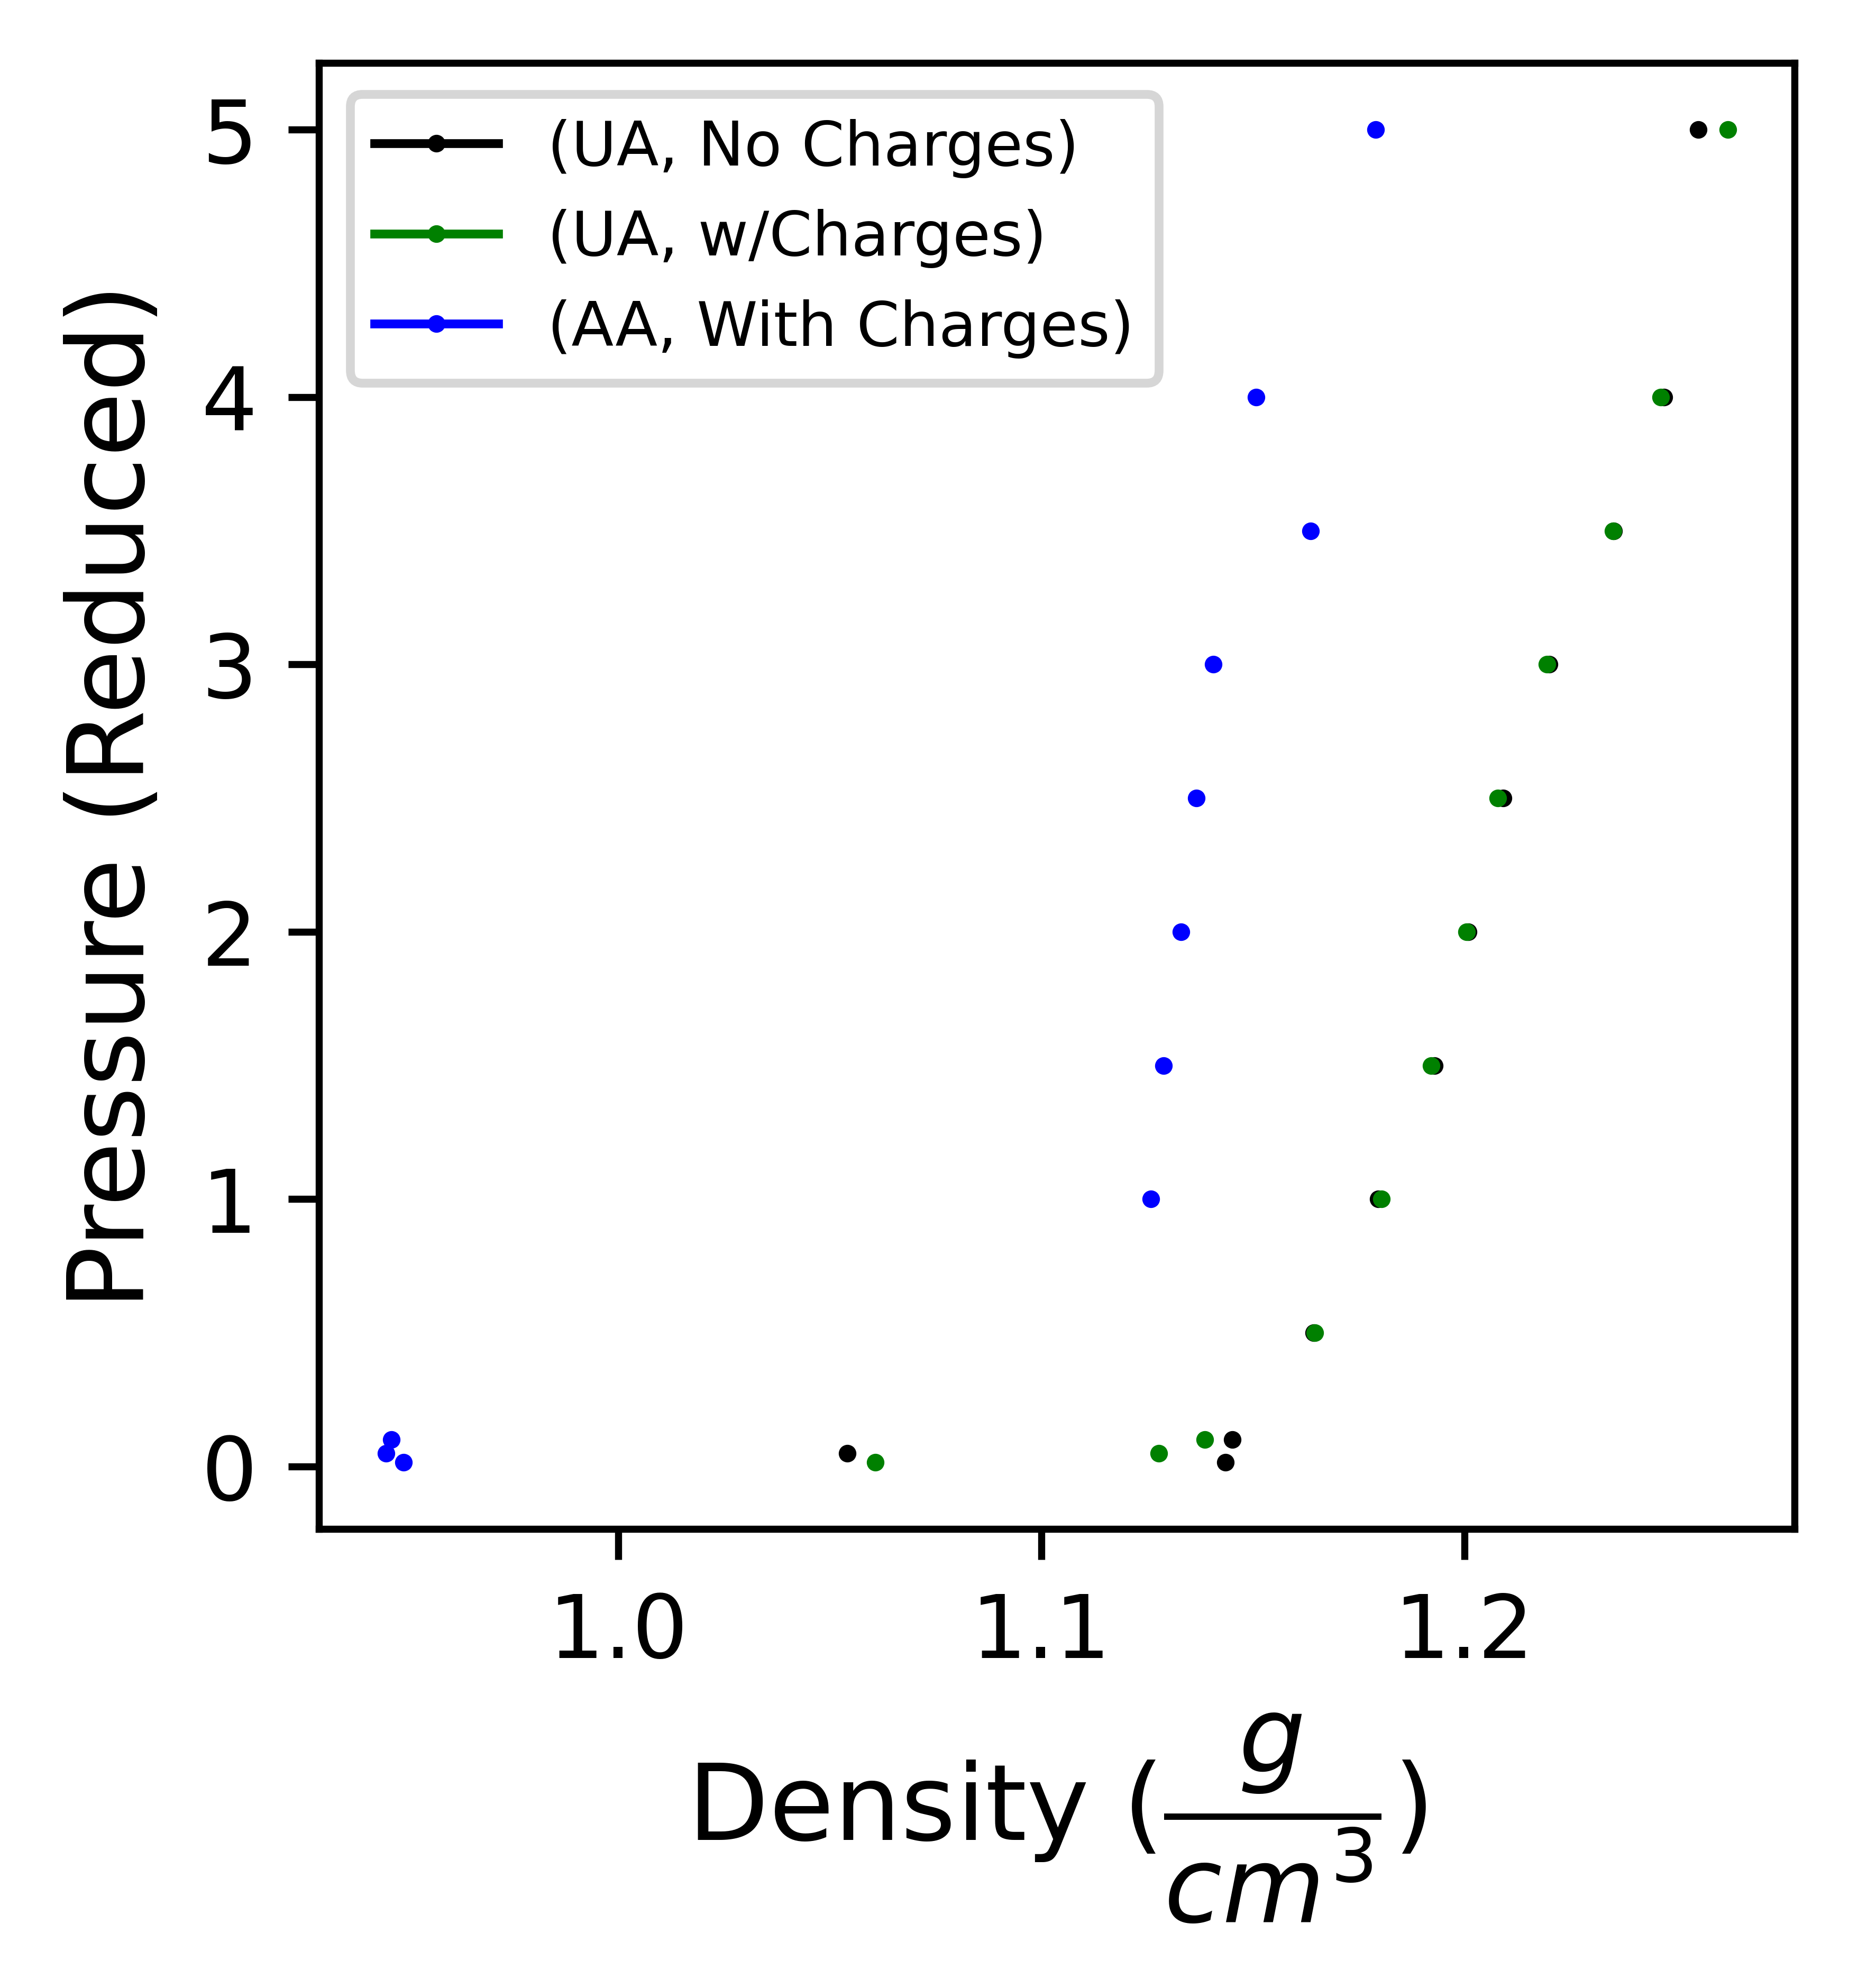

In [6]:
fig = plt.figure()
for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="k", label="(UA, No Charges)")

for P, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="g", label="(UA, w/Charges)")
    
for P, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": False}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.plot(job.doc.average_density, P, marker="o", c="blue", label="(AA, With Charges)")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Density $(\dfrac{g}{cm^3})$")
plt.ylabel("Pressure (Reduced)")

# Potential Energies:

Text(0, 0.5, '<PE> (per particle)')

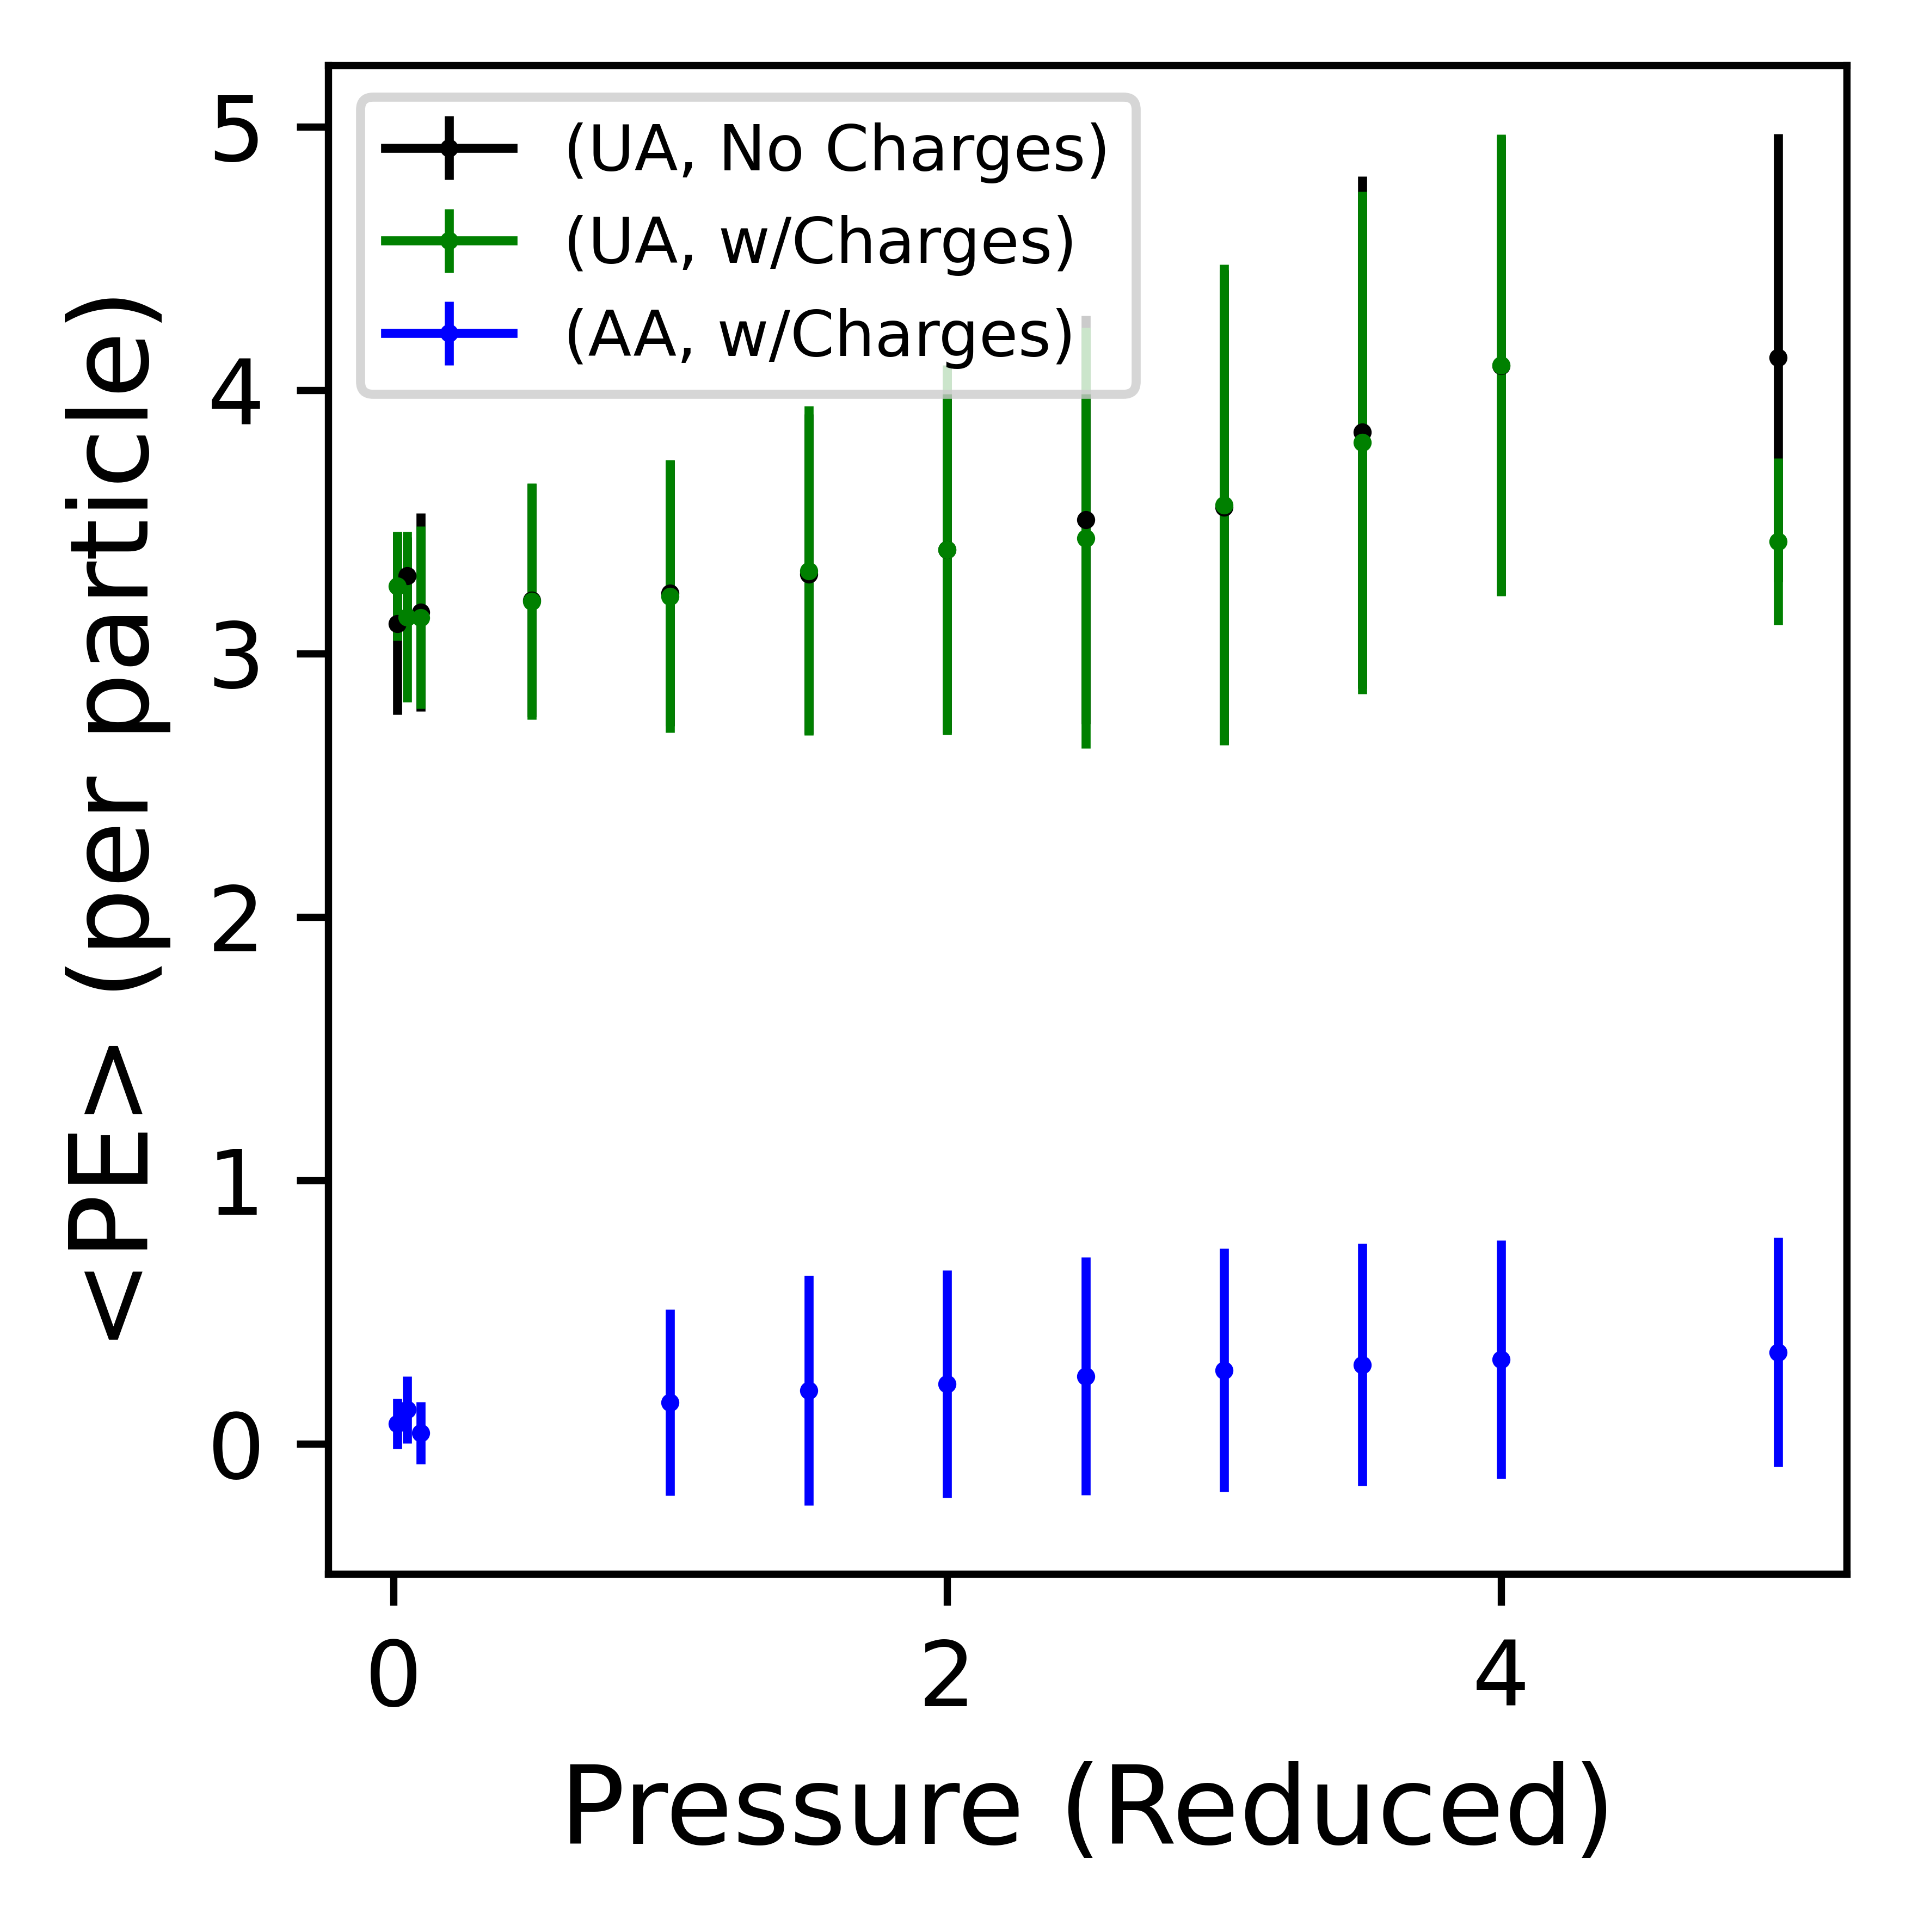

In [36]:
fig = plt.figure()
y = "average_pe"
err = "pe_std"
for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.errorbar(
        x=P, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="k", label="(UA, No Charges)"
    )
    
for P, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": True}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.errorbar(
        x=P, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="g", label="(UA, w/Charges)"
    )
    
for P, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": False}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.errorbar(
        x=P, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="blue", label="(AA, w/Charges)"
    )
    #print(den, job.ws)

for P, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": False}, doc_filter={"done": True, "sampled": True}).groupby("pressure"):
    job = list(job)[0]
    plt.errorbar(
        x=P, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="orange", label="(AA, No Charges)"
    )
    
#plt.vlines(x=1.32, ymin=3, ymax=3.25, label="Exp. Density Range", ls="--", color="r")
#plt.vlines(x=1.43, ymin=3, ymax=3.25, label="Exp. Density Range", ls="--", color="r")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left")
plt.xlabel("Pressure (Reduced)")
plt.ylabel("<PE> (per particle)")

#plt.ylim(3, 3.34)

# RDFs:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


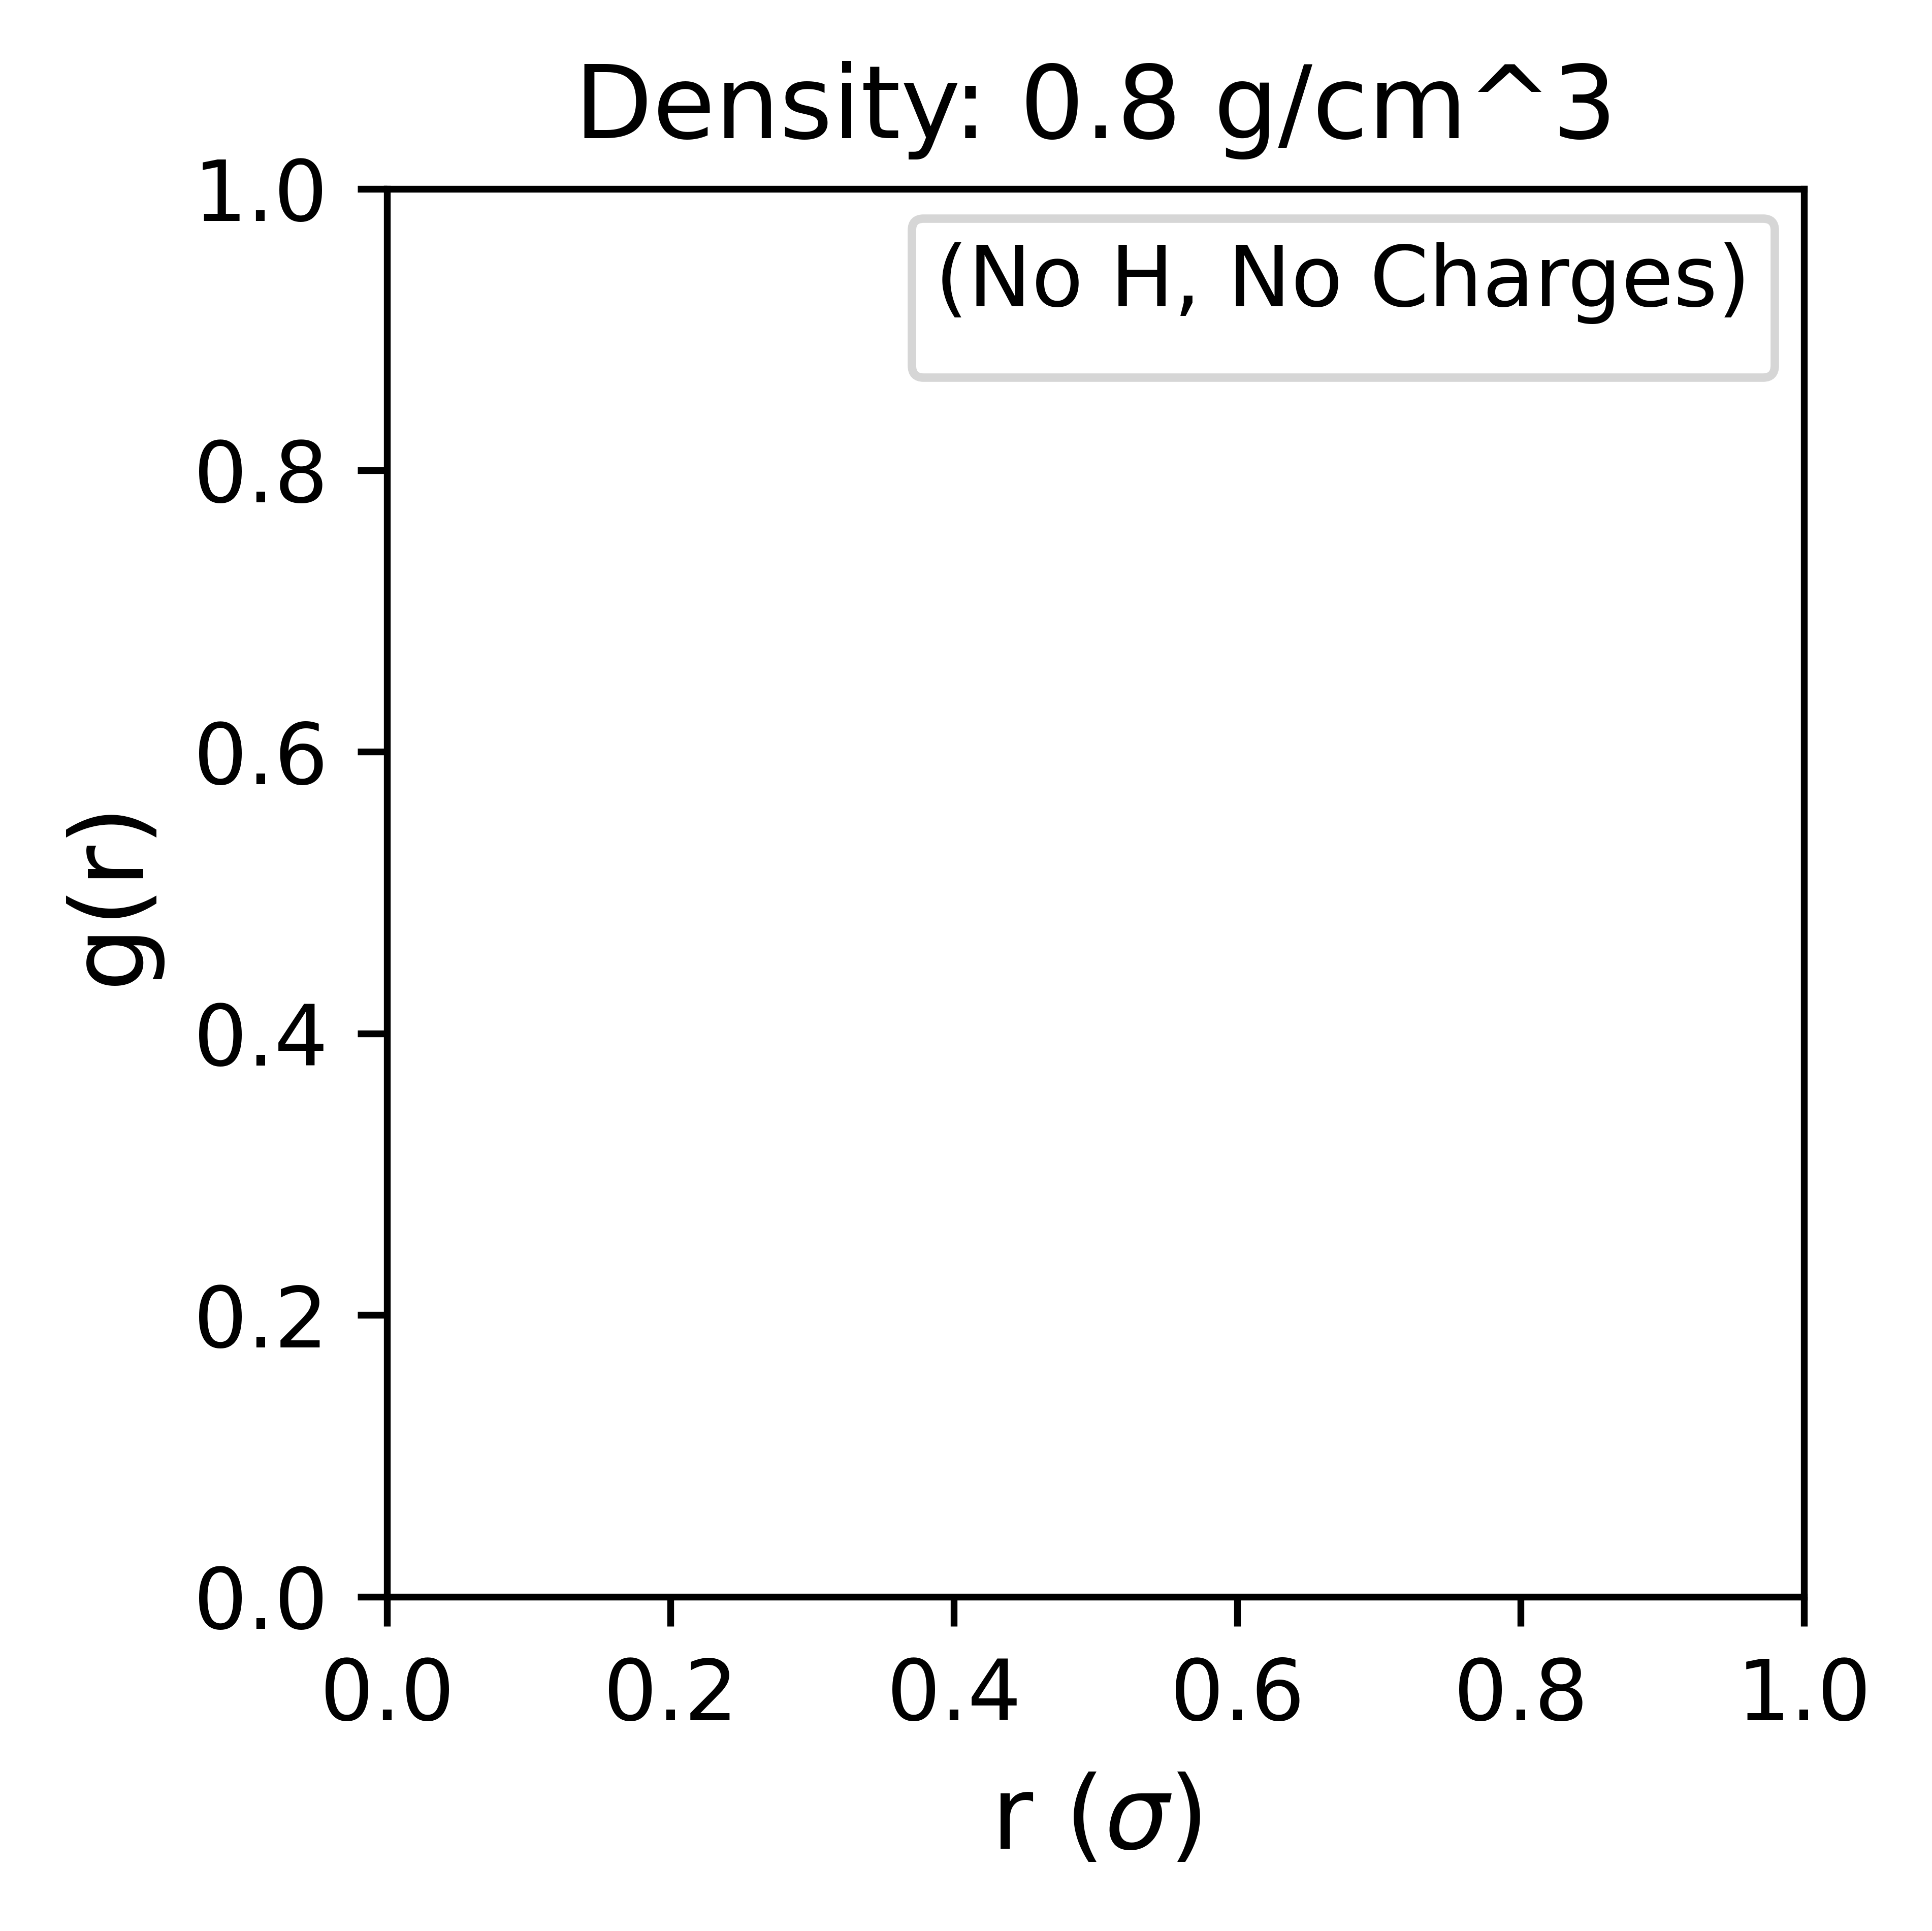

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


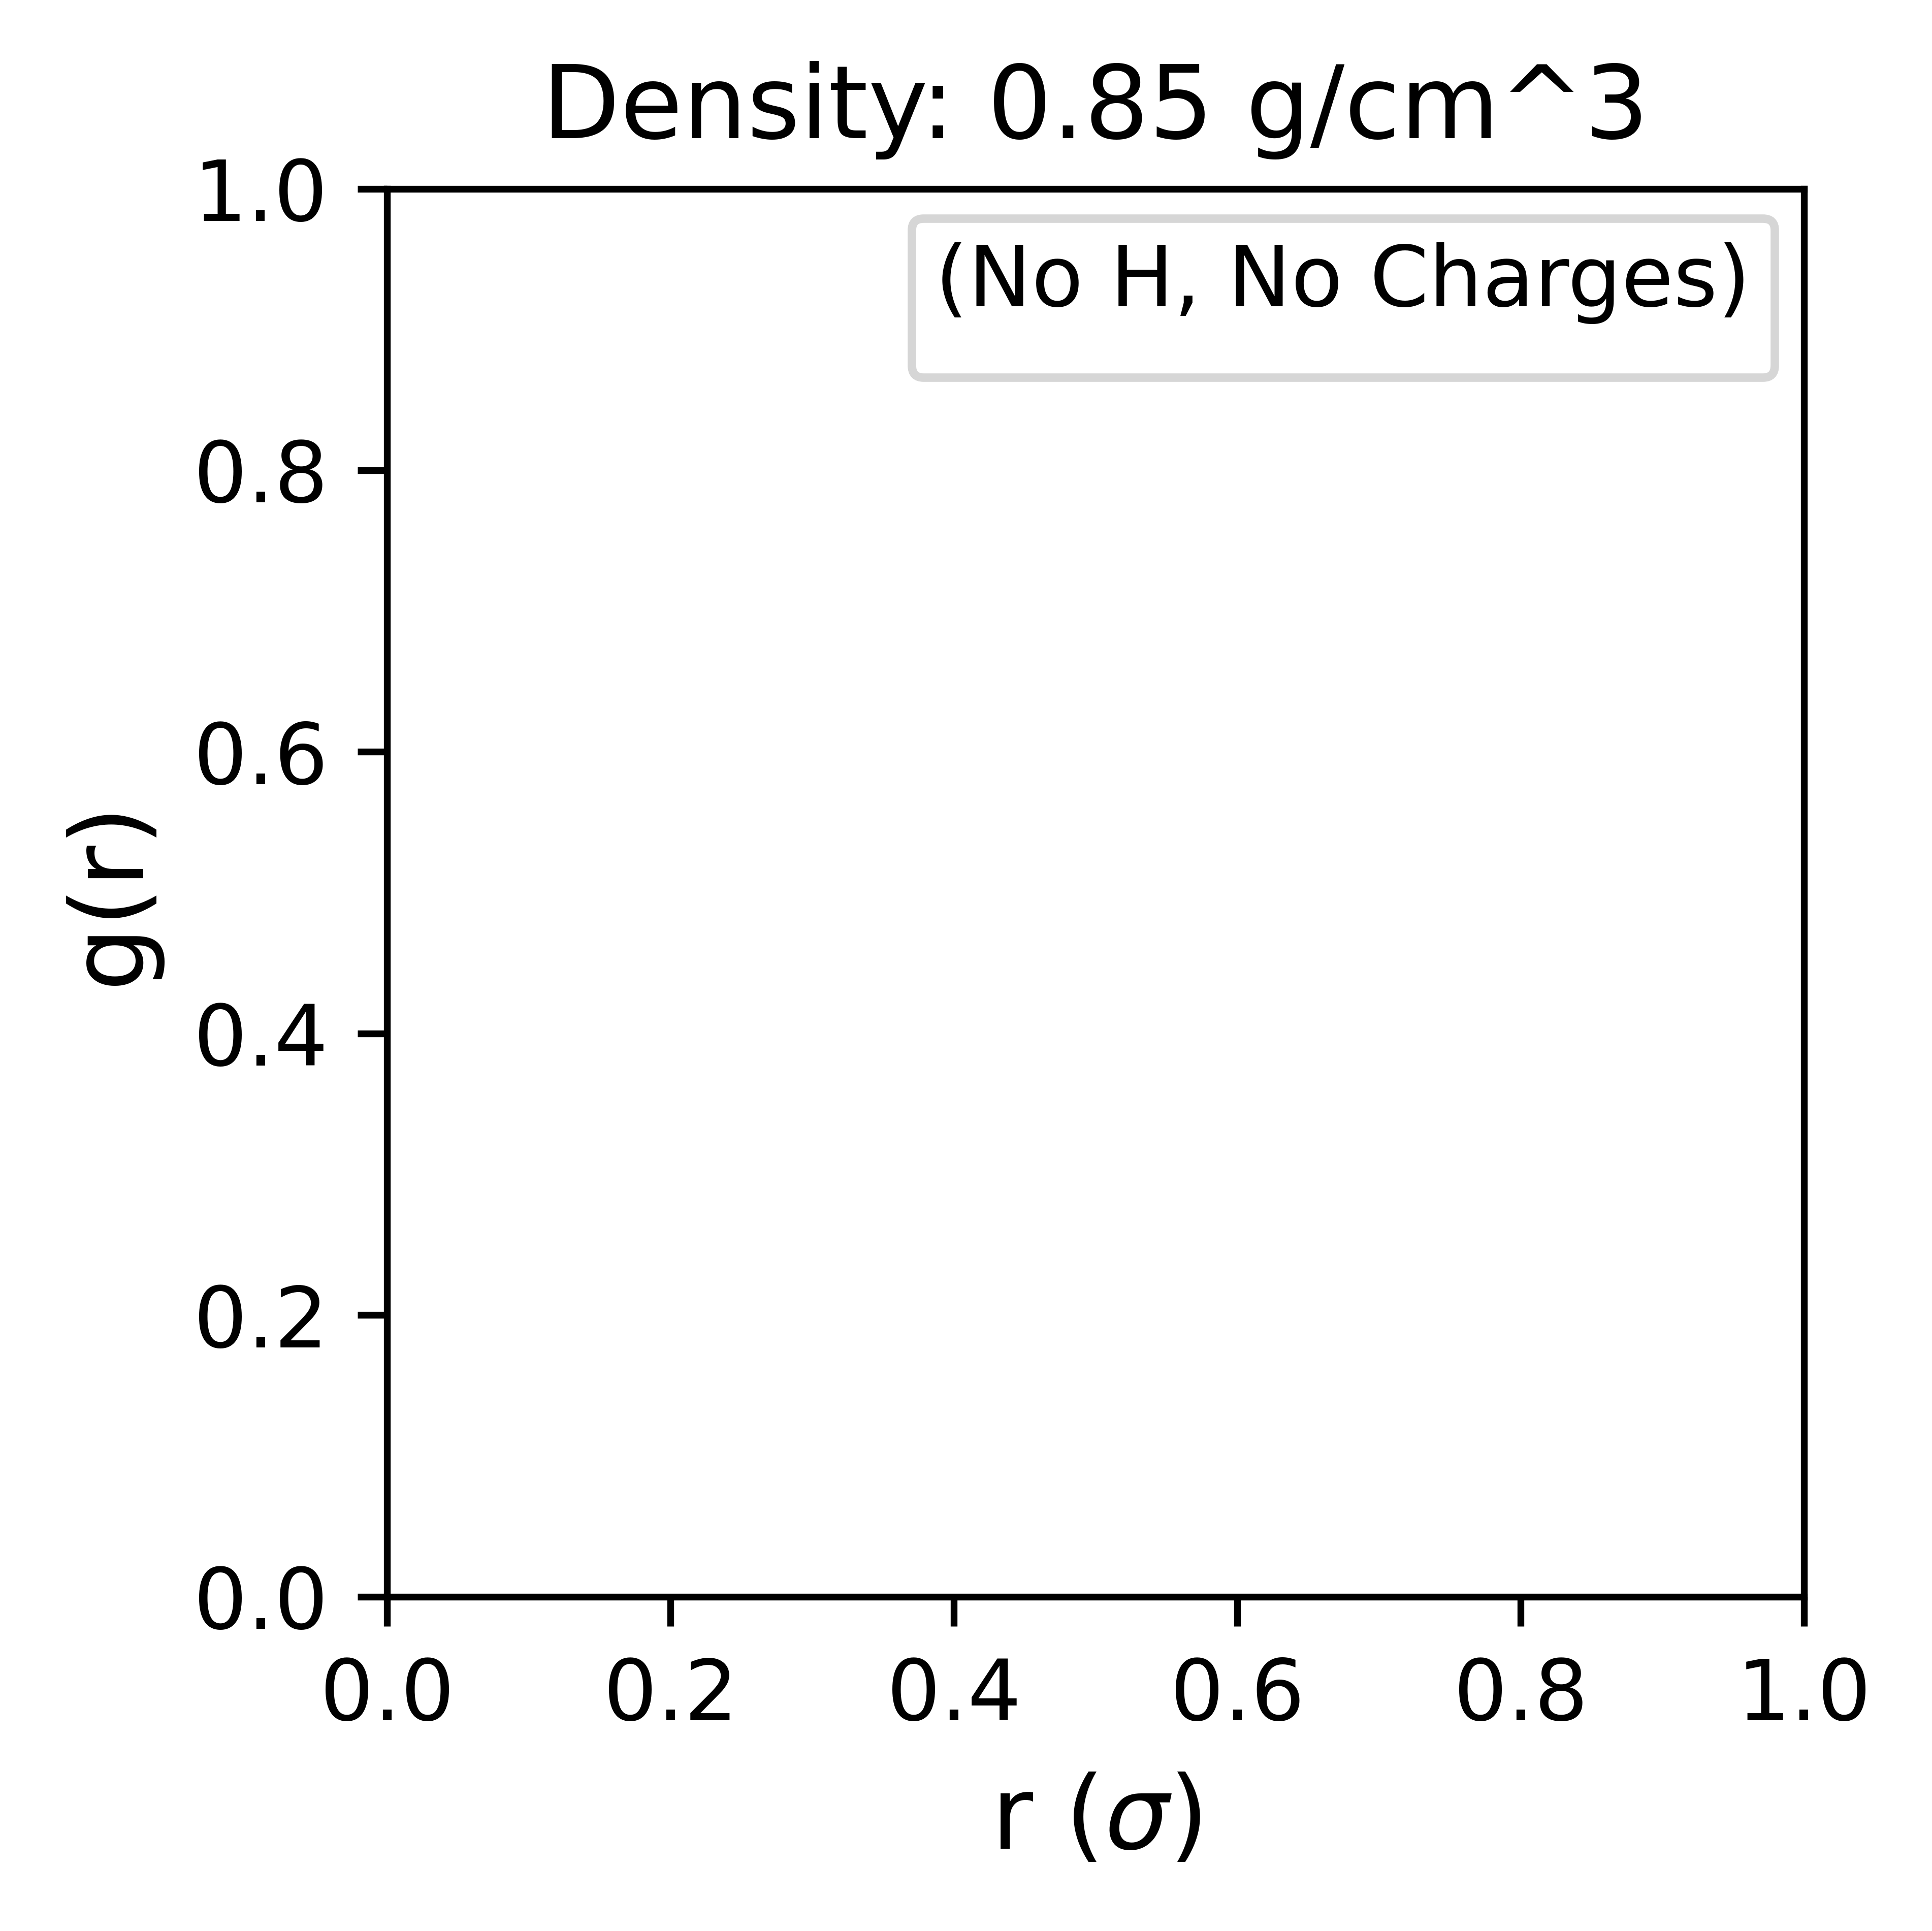

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


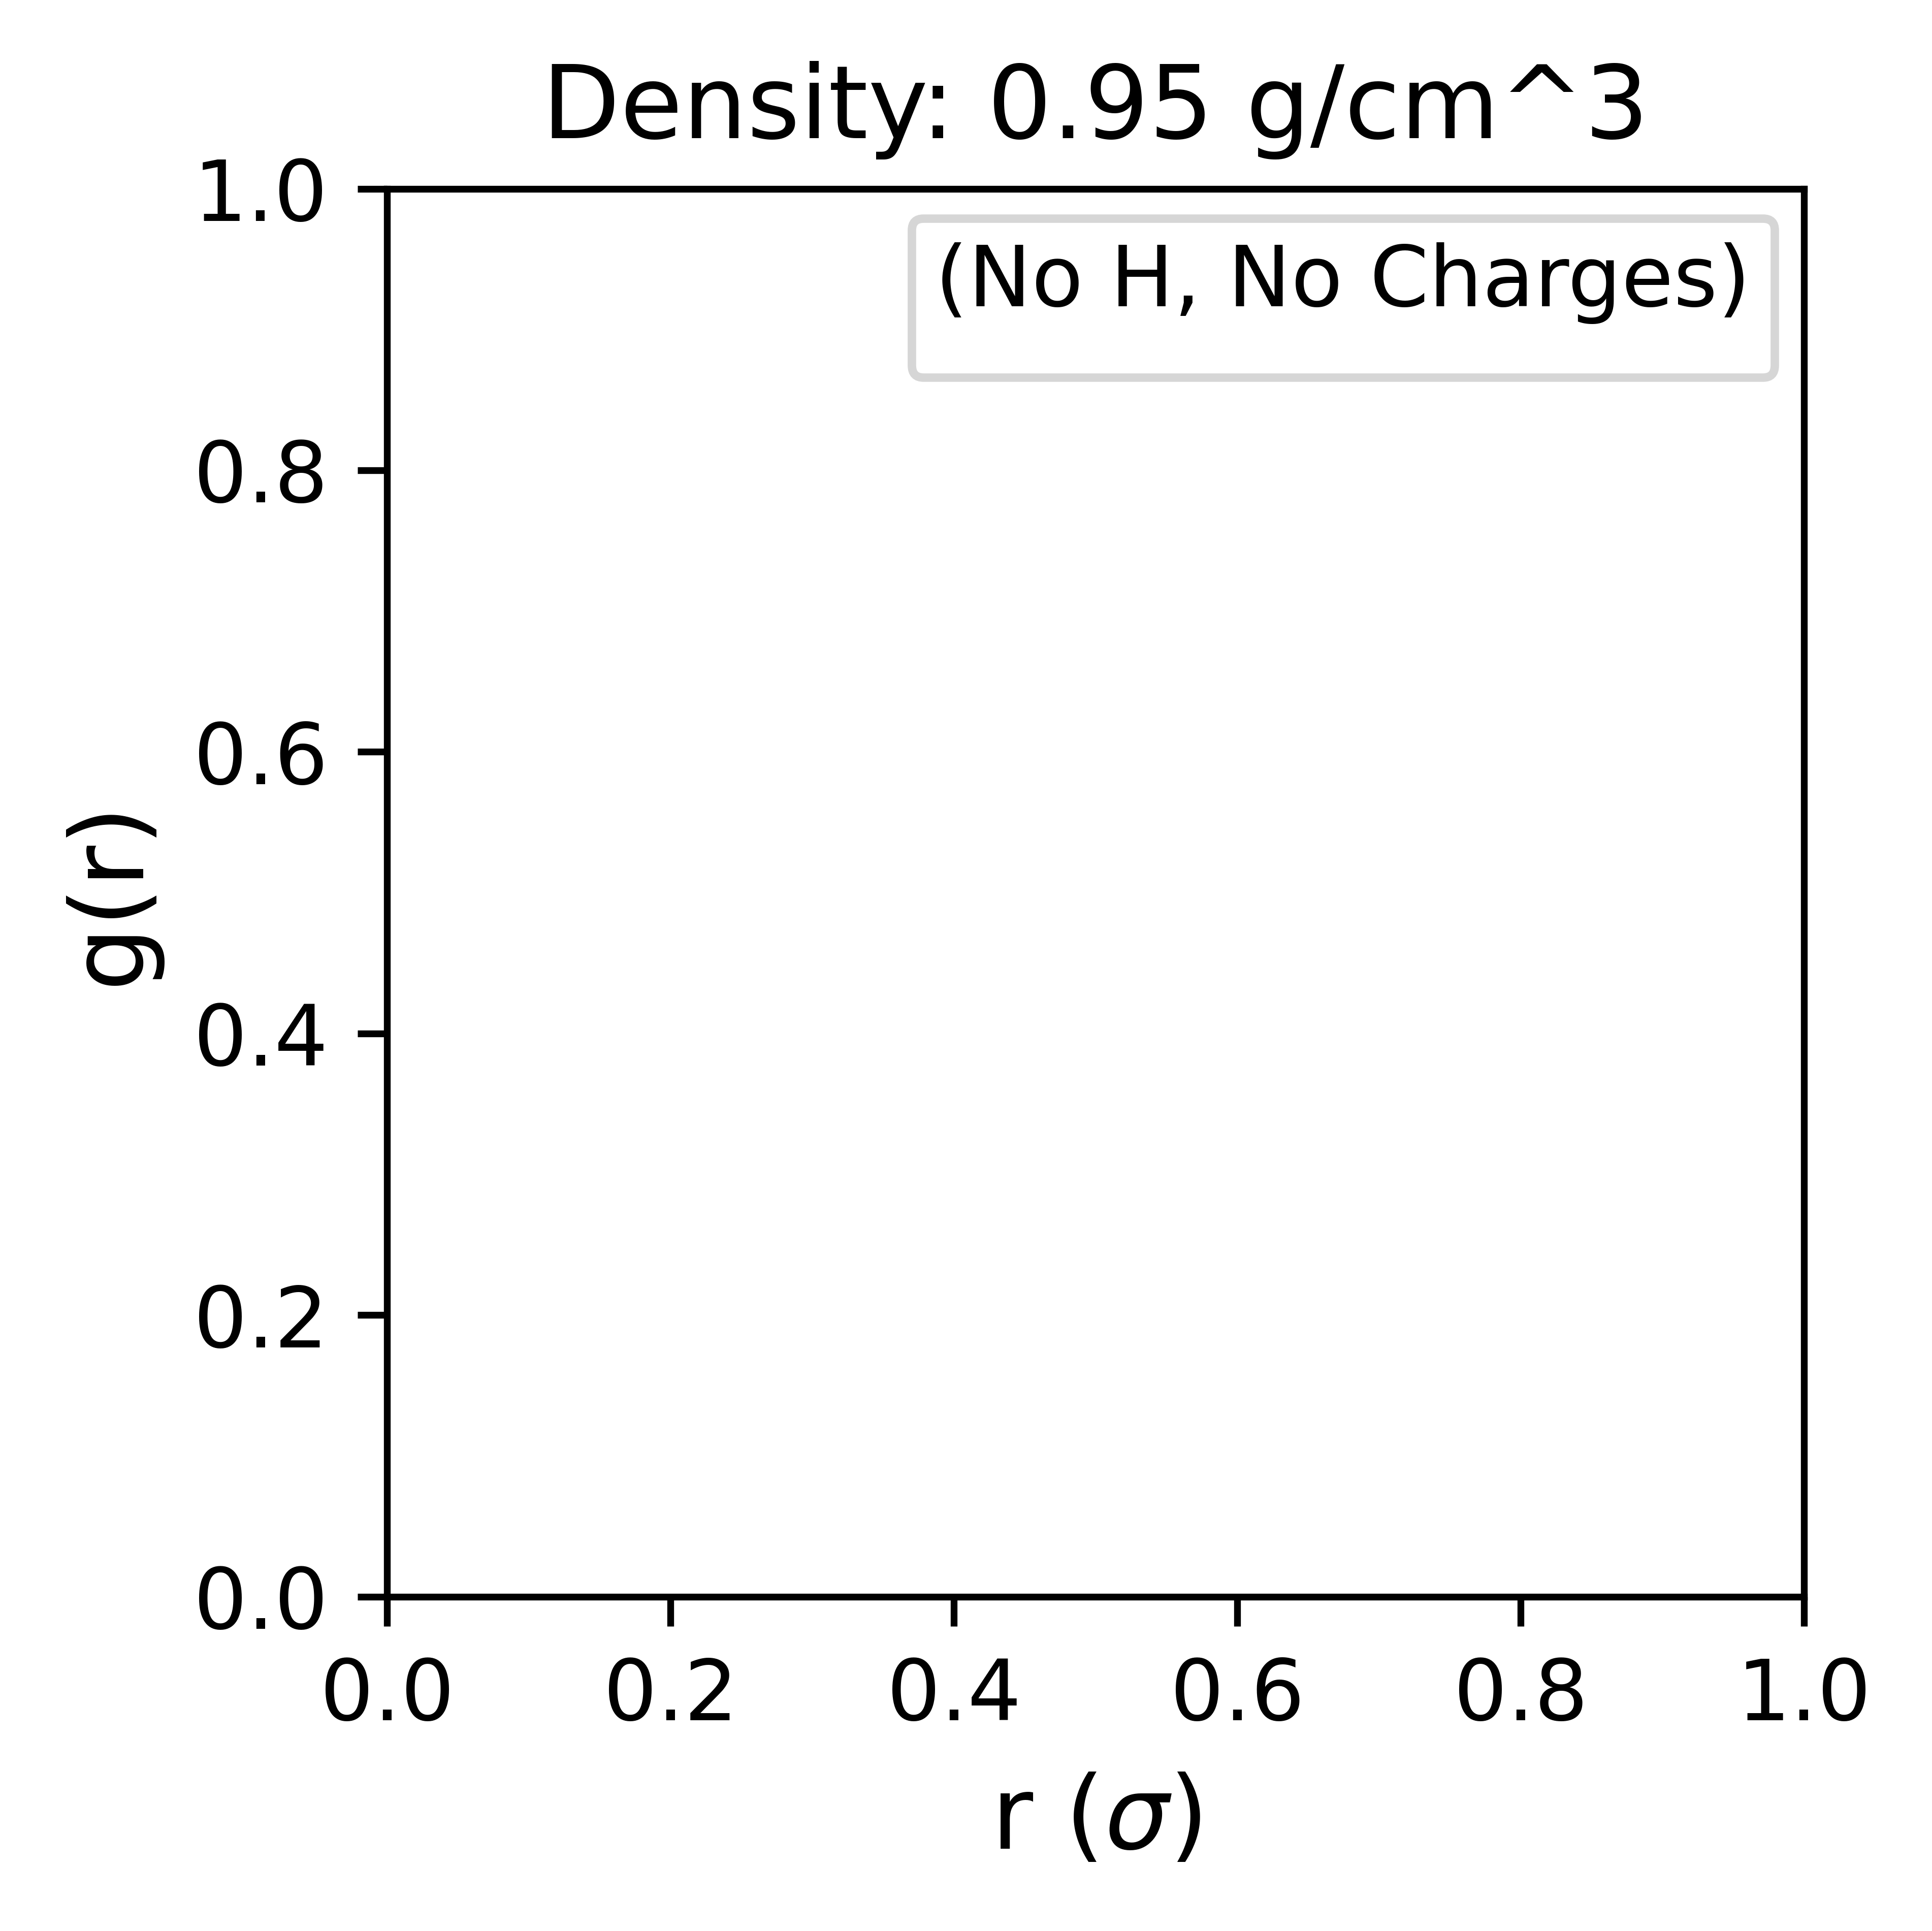

KeyboardInterrupt: 

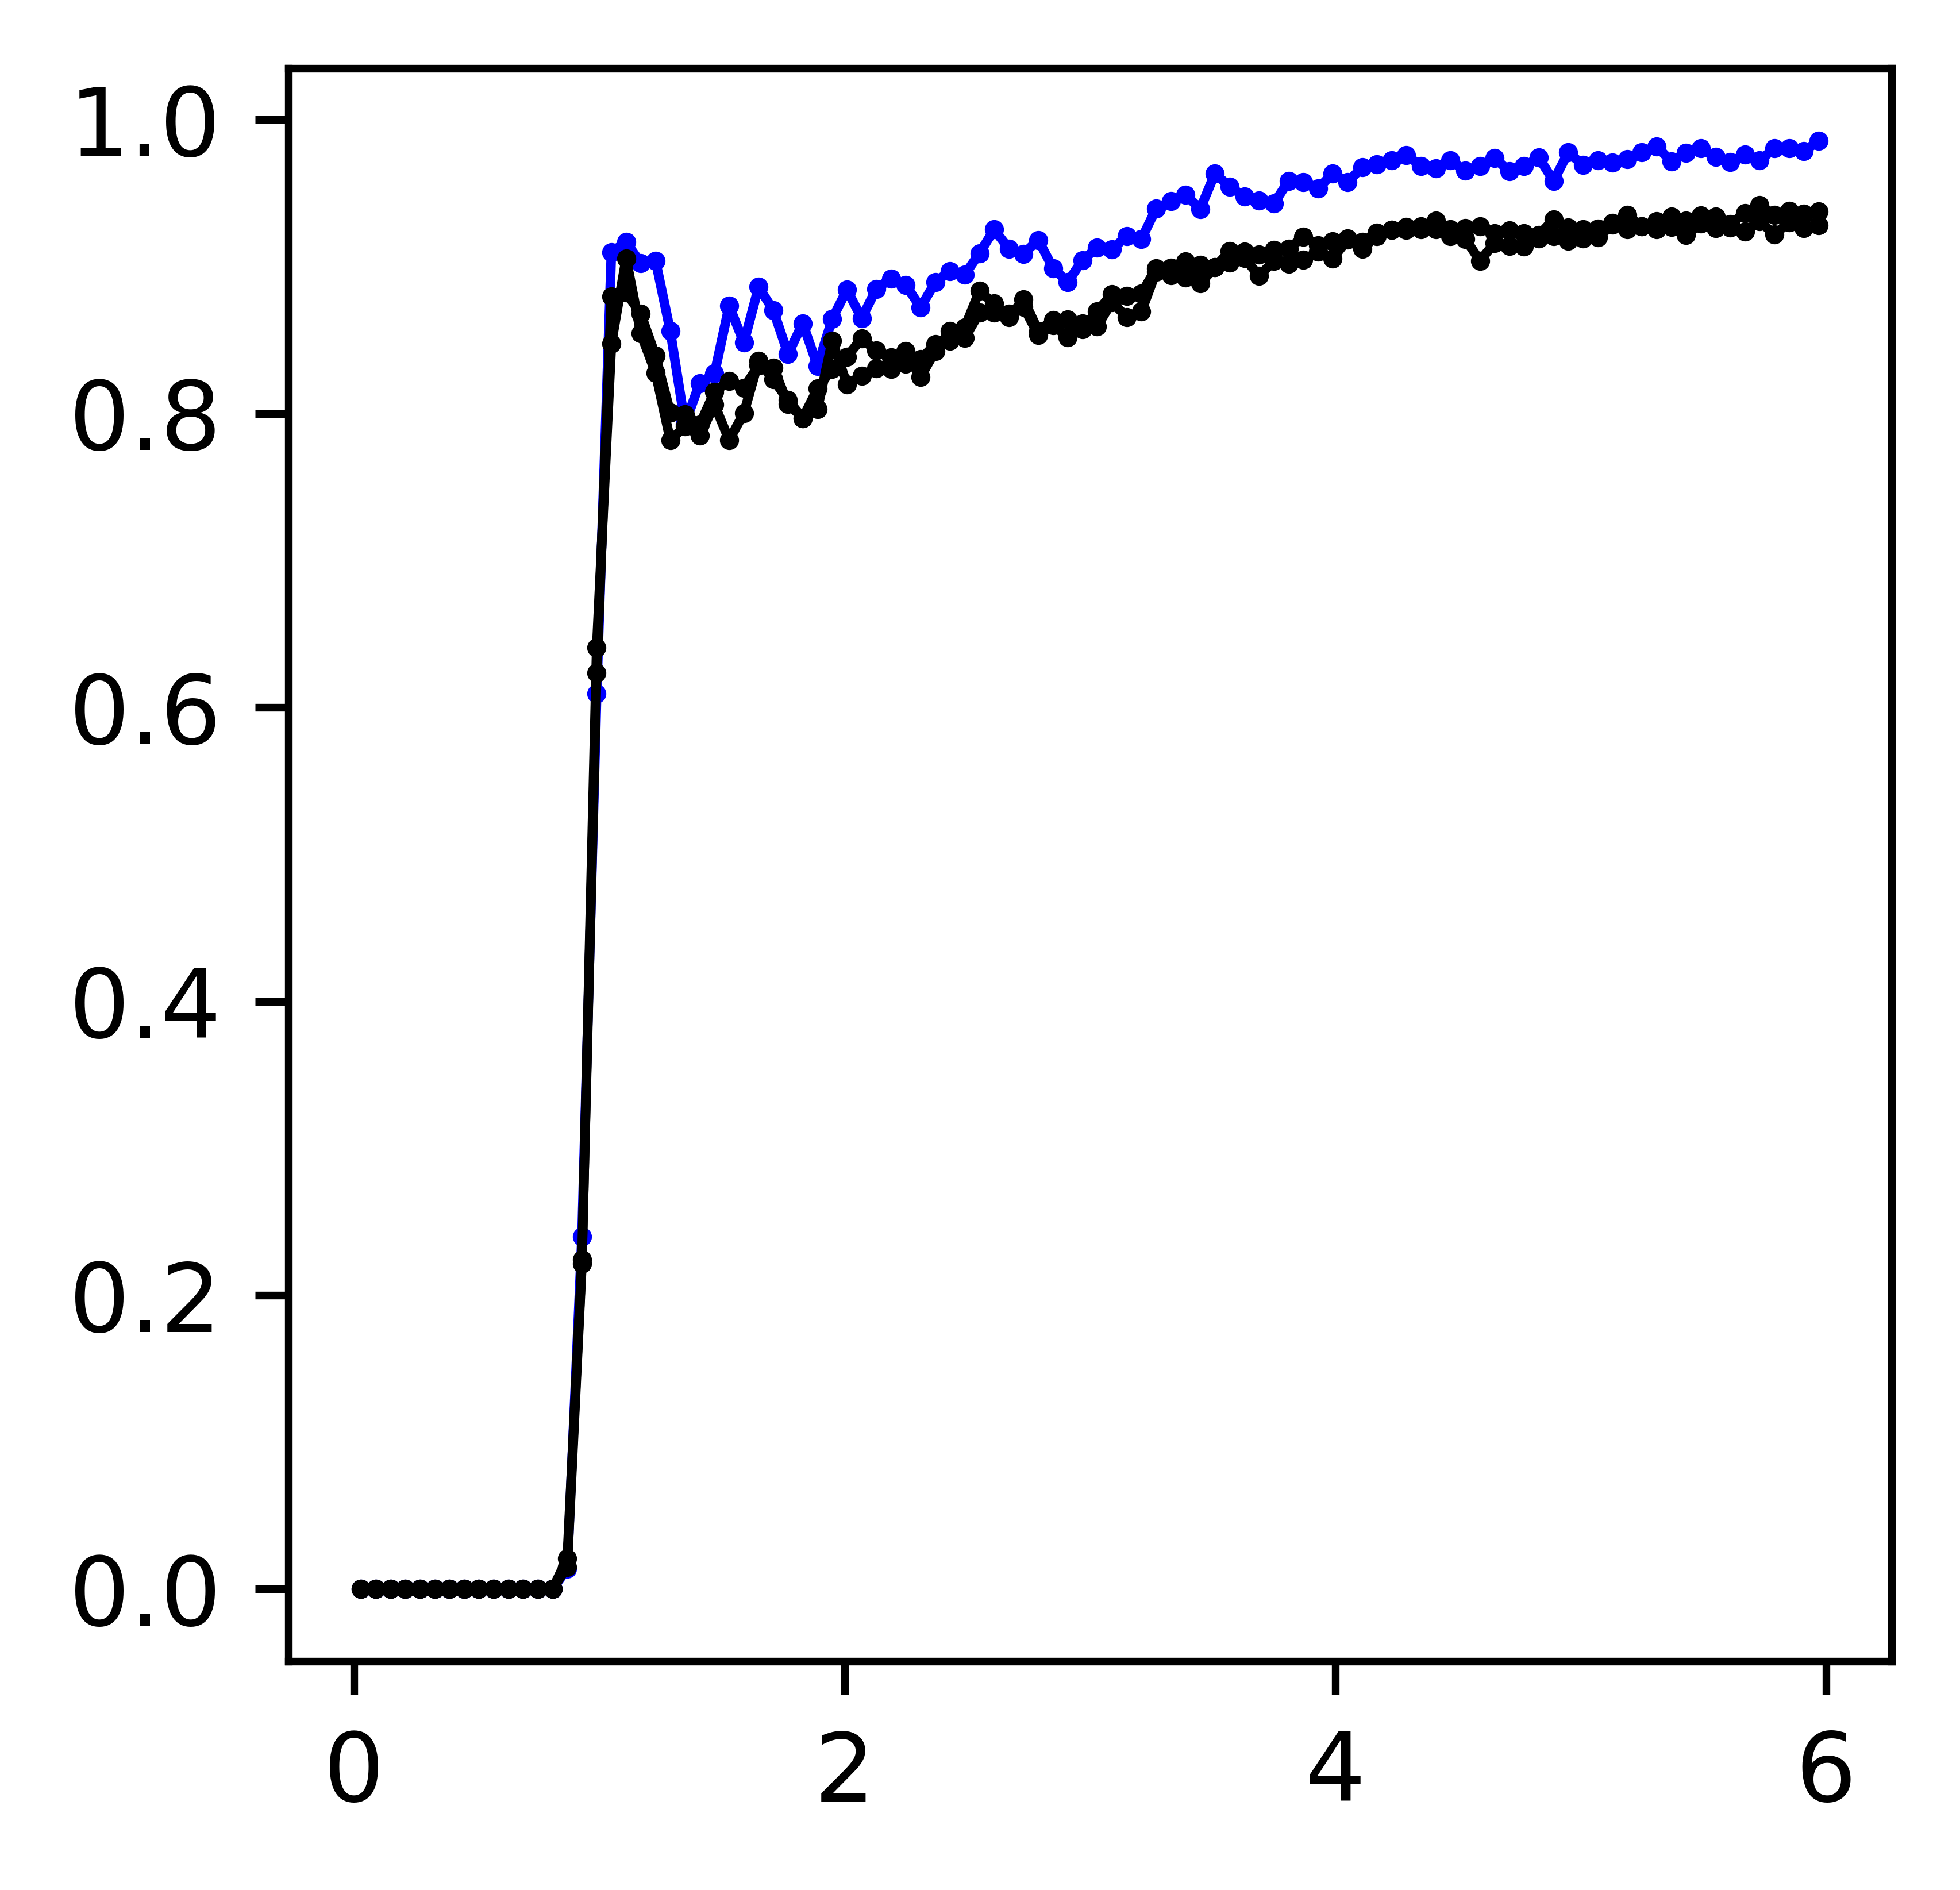

In [21]:
for den in densities:
    fig = plt.figure()
    for job in project.find_jobs({"density": den}, {"done": True}):
        rdf, N = cmeutils.structure.gsd_rdf(
            gsdfile=job.fn("trajectory.gsd"),
            A_name="s",
            B_name="s",
            start=-20,
            stop=-1,
            exclude_bonded=True,
            r_max=6
        )
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        c = color_dict[label]
        plt.plot(rdf.bin_centers, rdf.rdf*N, label=label, c=color_dict[label])
        
    plt.legend(title=("(No H, No Charges)"))
    plt.title(f"Density: {den} g/cm^3")
    plt.xlabel("r ($\sigma$)")
    plt.ylabel("g(r)")
    plt.show()

In [17]:
for job in project.find_jobs({"density": 1.3}):
    print(job.ws, job.sp.remove_hydrogens, job.sp.remove_charges)

/home/erjank_project/chrisjones/validate-PPS/validate-pps/pps-flow/workspace/8d9c377686884ed8855b9187c8010148 False False
/home/erjank_project/chrisjones/validate-PPS/validate-pps/pps-flow/workspace/c75d4586c59ad1f118ae66c6479c80b7 False True
/home/erjank_project/chrisjones/validate-PPS/validate-pps/pps-flow/workspace/47f079616b37a29422b611254fafa366 True False
/home/erjank_project/chrisjones/validate-PPS/validate-pps/pps-flow/workspace/ddb012c2de35cd93a8a7c154c059897a True True


In [ ]:
n_colors = len(densities)
gradient = cm.get_cmap('plasma', n_colors)
newcolors = gradient(np.linspace(0, 1, n_colors))

for combo in [(True, True), (True, False), (False, False), (False, True)]:
    fig = plt.figure()
    count = 0
    for den, job in project.find_jobs(
        {"remove_hydrogens": combo[0], "remove_charges": combo[1]}, {"done": True}).groupby("density"):
        job = list(job)[0]
        rdf, N = cmeutils.structure.gsd_rdf(
            gsdfile=job.fn("trajectory.gsd"),
            A_name="s",
            B_name="s",
            start=-50,
            stop=-1,
            exclude_bonded=True,
            r_max=3.0
        )
        plt.plot(rdf.bin_centers, rdf.rdf*N, label=den, c=newcolors[count])
        count += 1
        
    plt.title((f"Remove H: {combo[0]}, Remove Charges: {combo[1]}"))
    plt.legend(title="Den.")
    plt.xlabel("r ($\sigma$)")
    plt.ylabel("g(r)")
    plt.show()

In [ ]:
fig = plt.figure()

for den in densities:
    for job in project.find_jobs({"density": den}, {"done": True}):
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        plt.plot(den, job.doc.total_time*1e-6, c=color_dict[label], label=label, marker="o")
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title=("(Remove H, Remove Charges)"),
    loc=(1.1, 0.5)
)
plt.title("Time to Equilibration")
plt.xlabel("Density")
plt.ylabel("Time (ns)")
plt.show()

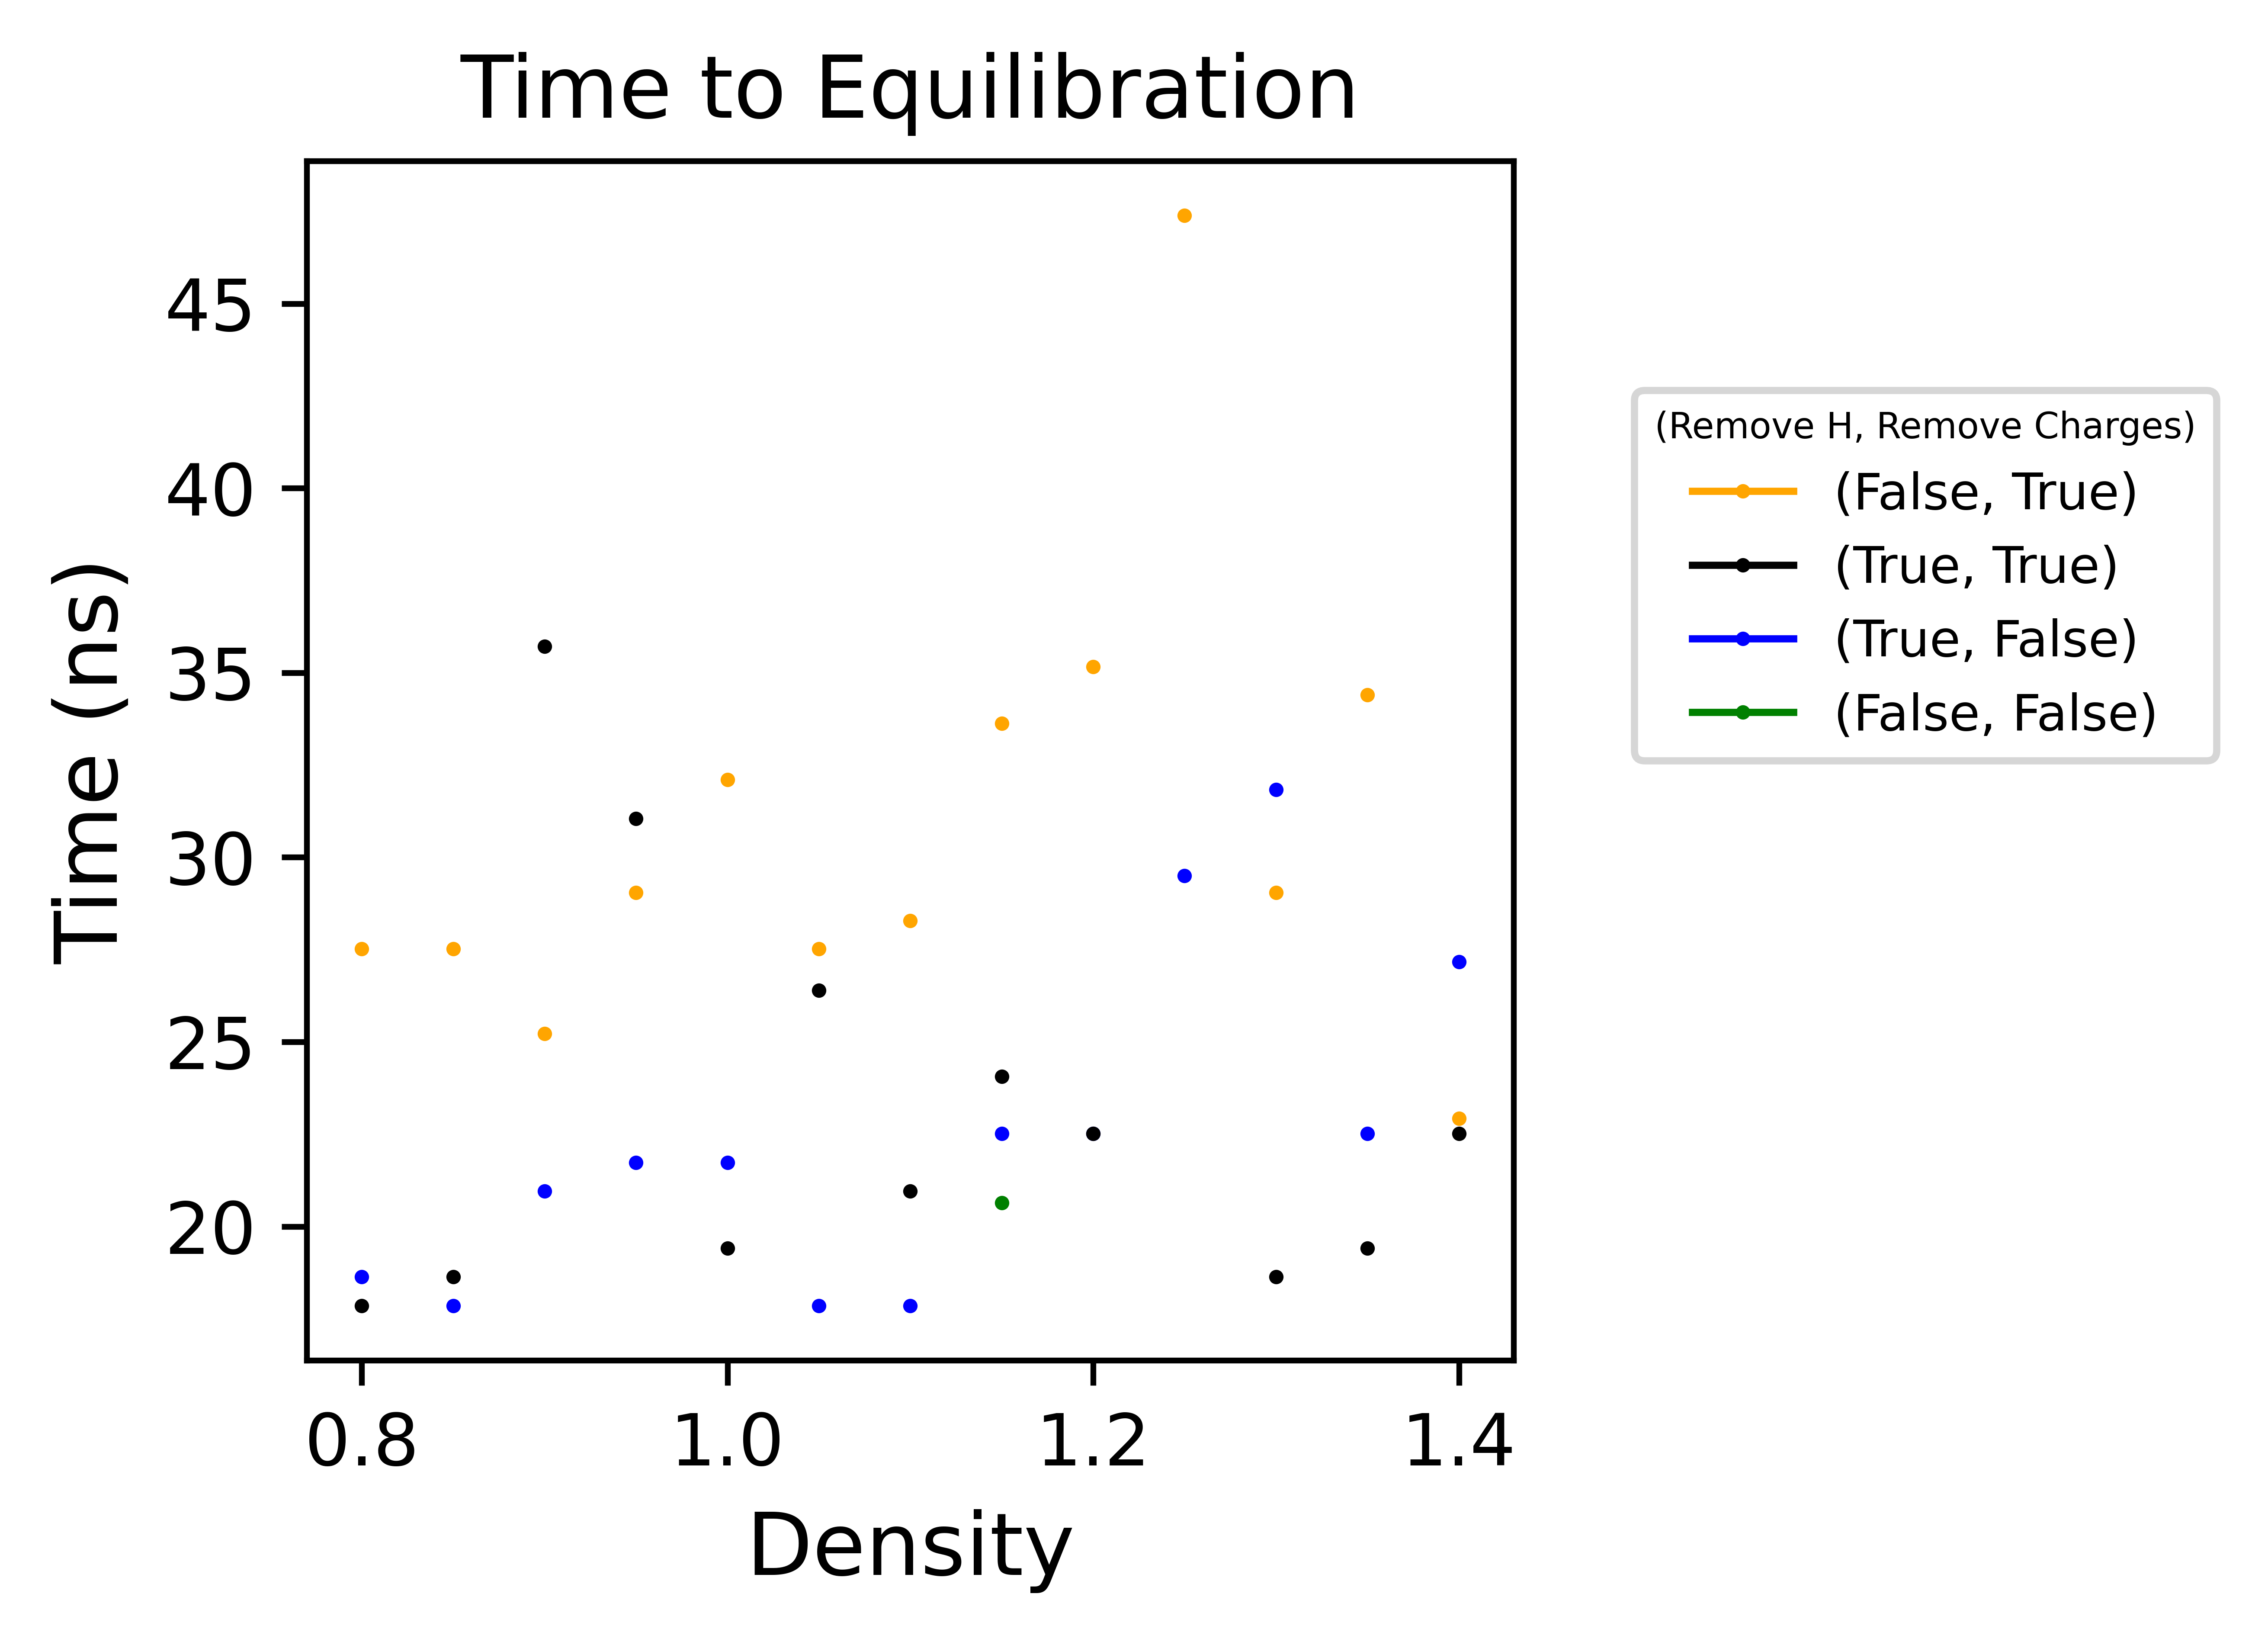

In [13]:
fig = plt.figure()

for den in densities:
    for job in project.find_jobs({"density": den}, {"done": True}):
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        plt.plot(den, job.doc.total_time*1e-6, c=color_dict[label], label=label, marker="o")
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title=("(Remove H, Remove Charges)"),
    title_fontsize=5,
    loc=(1.1, 0.5)
)
plt.title("Time to Equilibration")
plt.xlabel("Density")
plt.ylabel("Time (ns)")
plt.show()

In [10]:
job = project.open_job(id="fad29186e931c698a2afdb4a2c120317")

In [8]:
job.doc.done

False

In [34]:
sample_job(job)

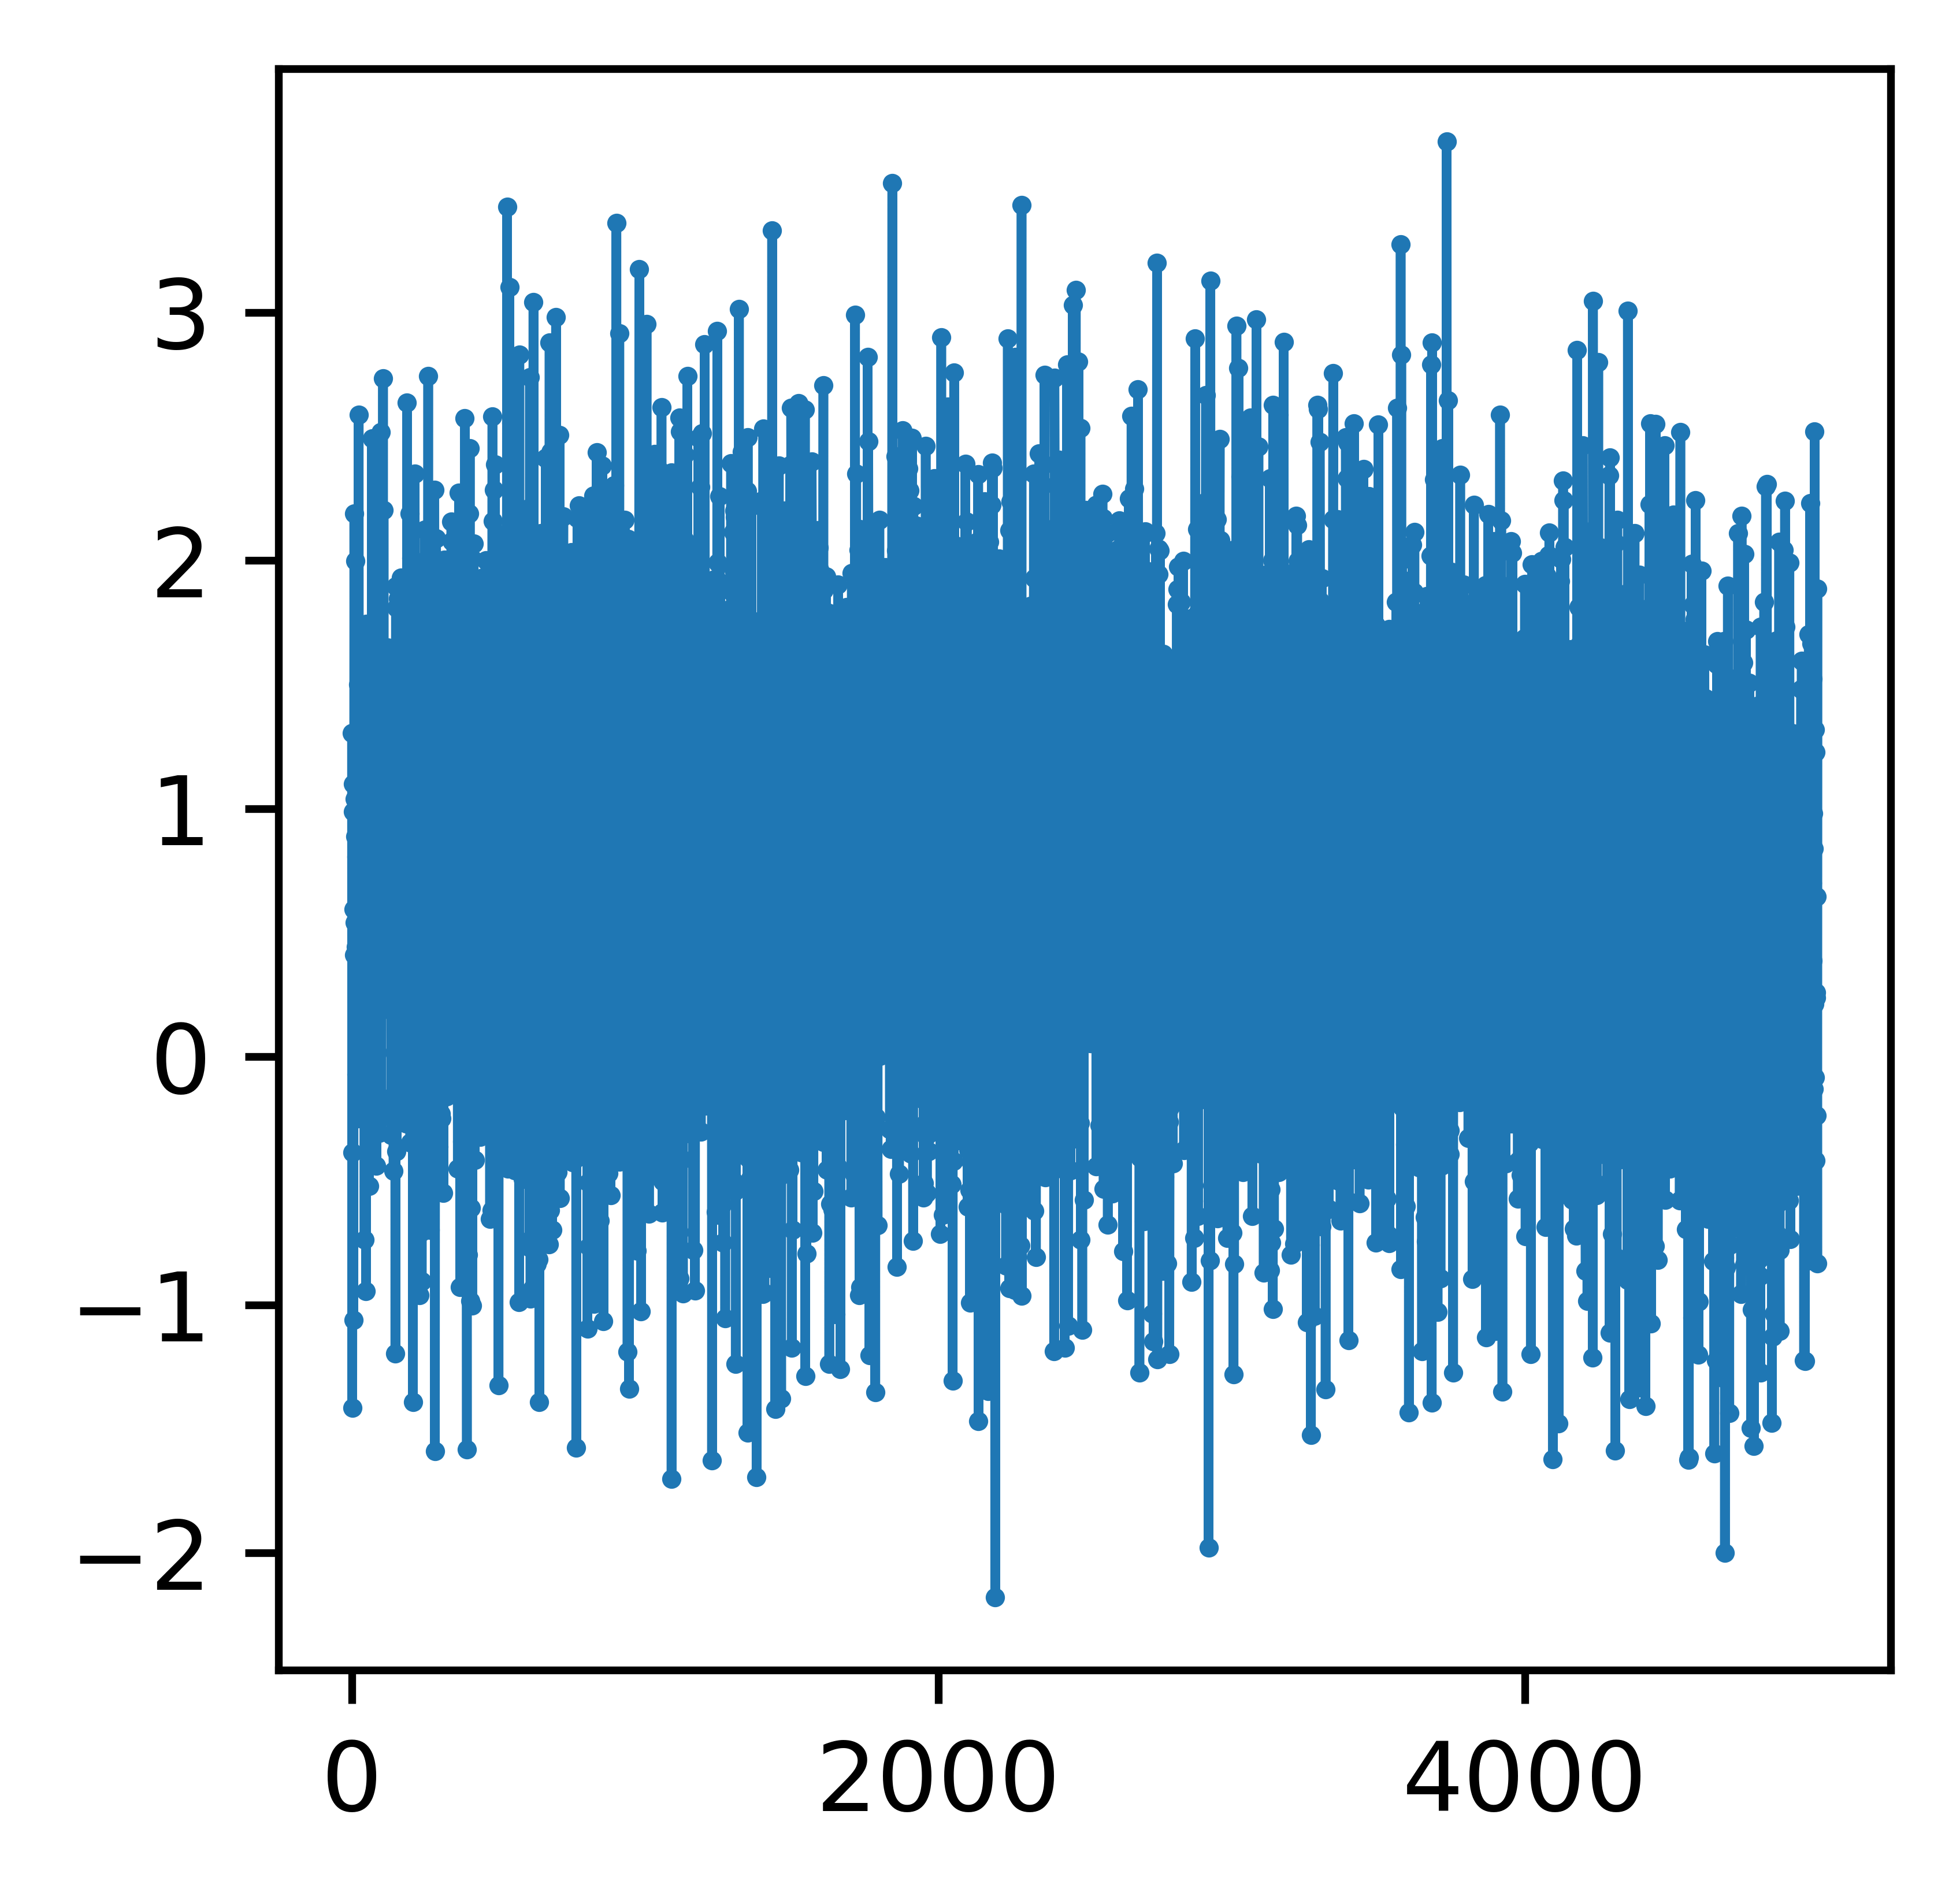

In [25]:
data = np.genfromtxt(job.fn("sim_data.txt"), names=True)
pressure = data["mdcomputeThermodynamicQuantitiespressure"]
plt.plot(pressure[-5000:])

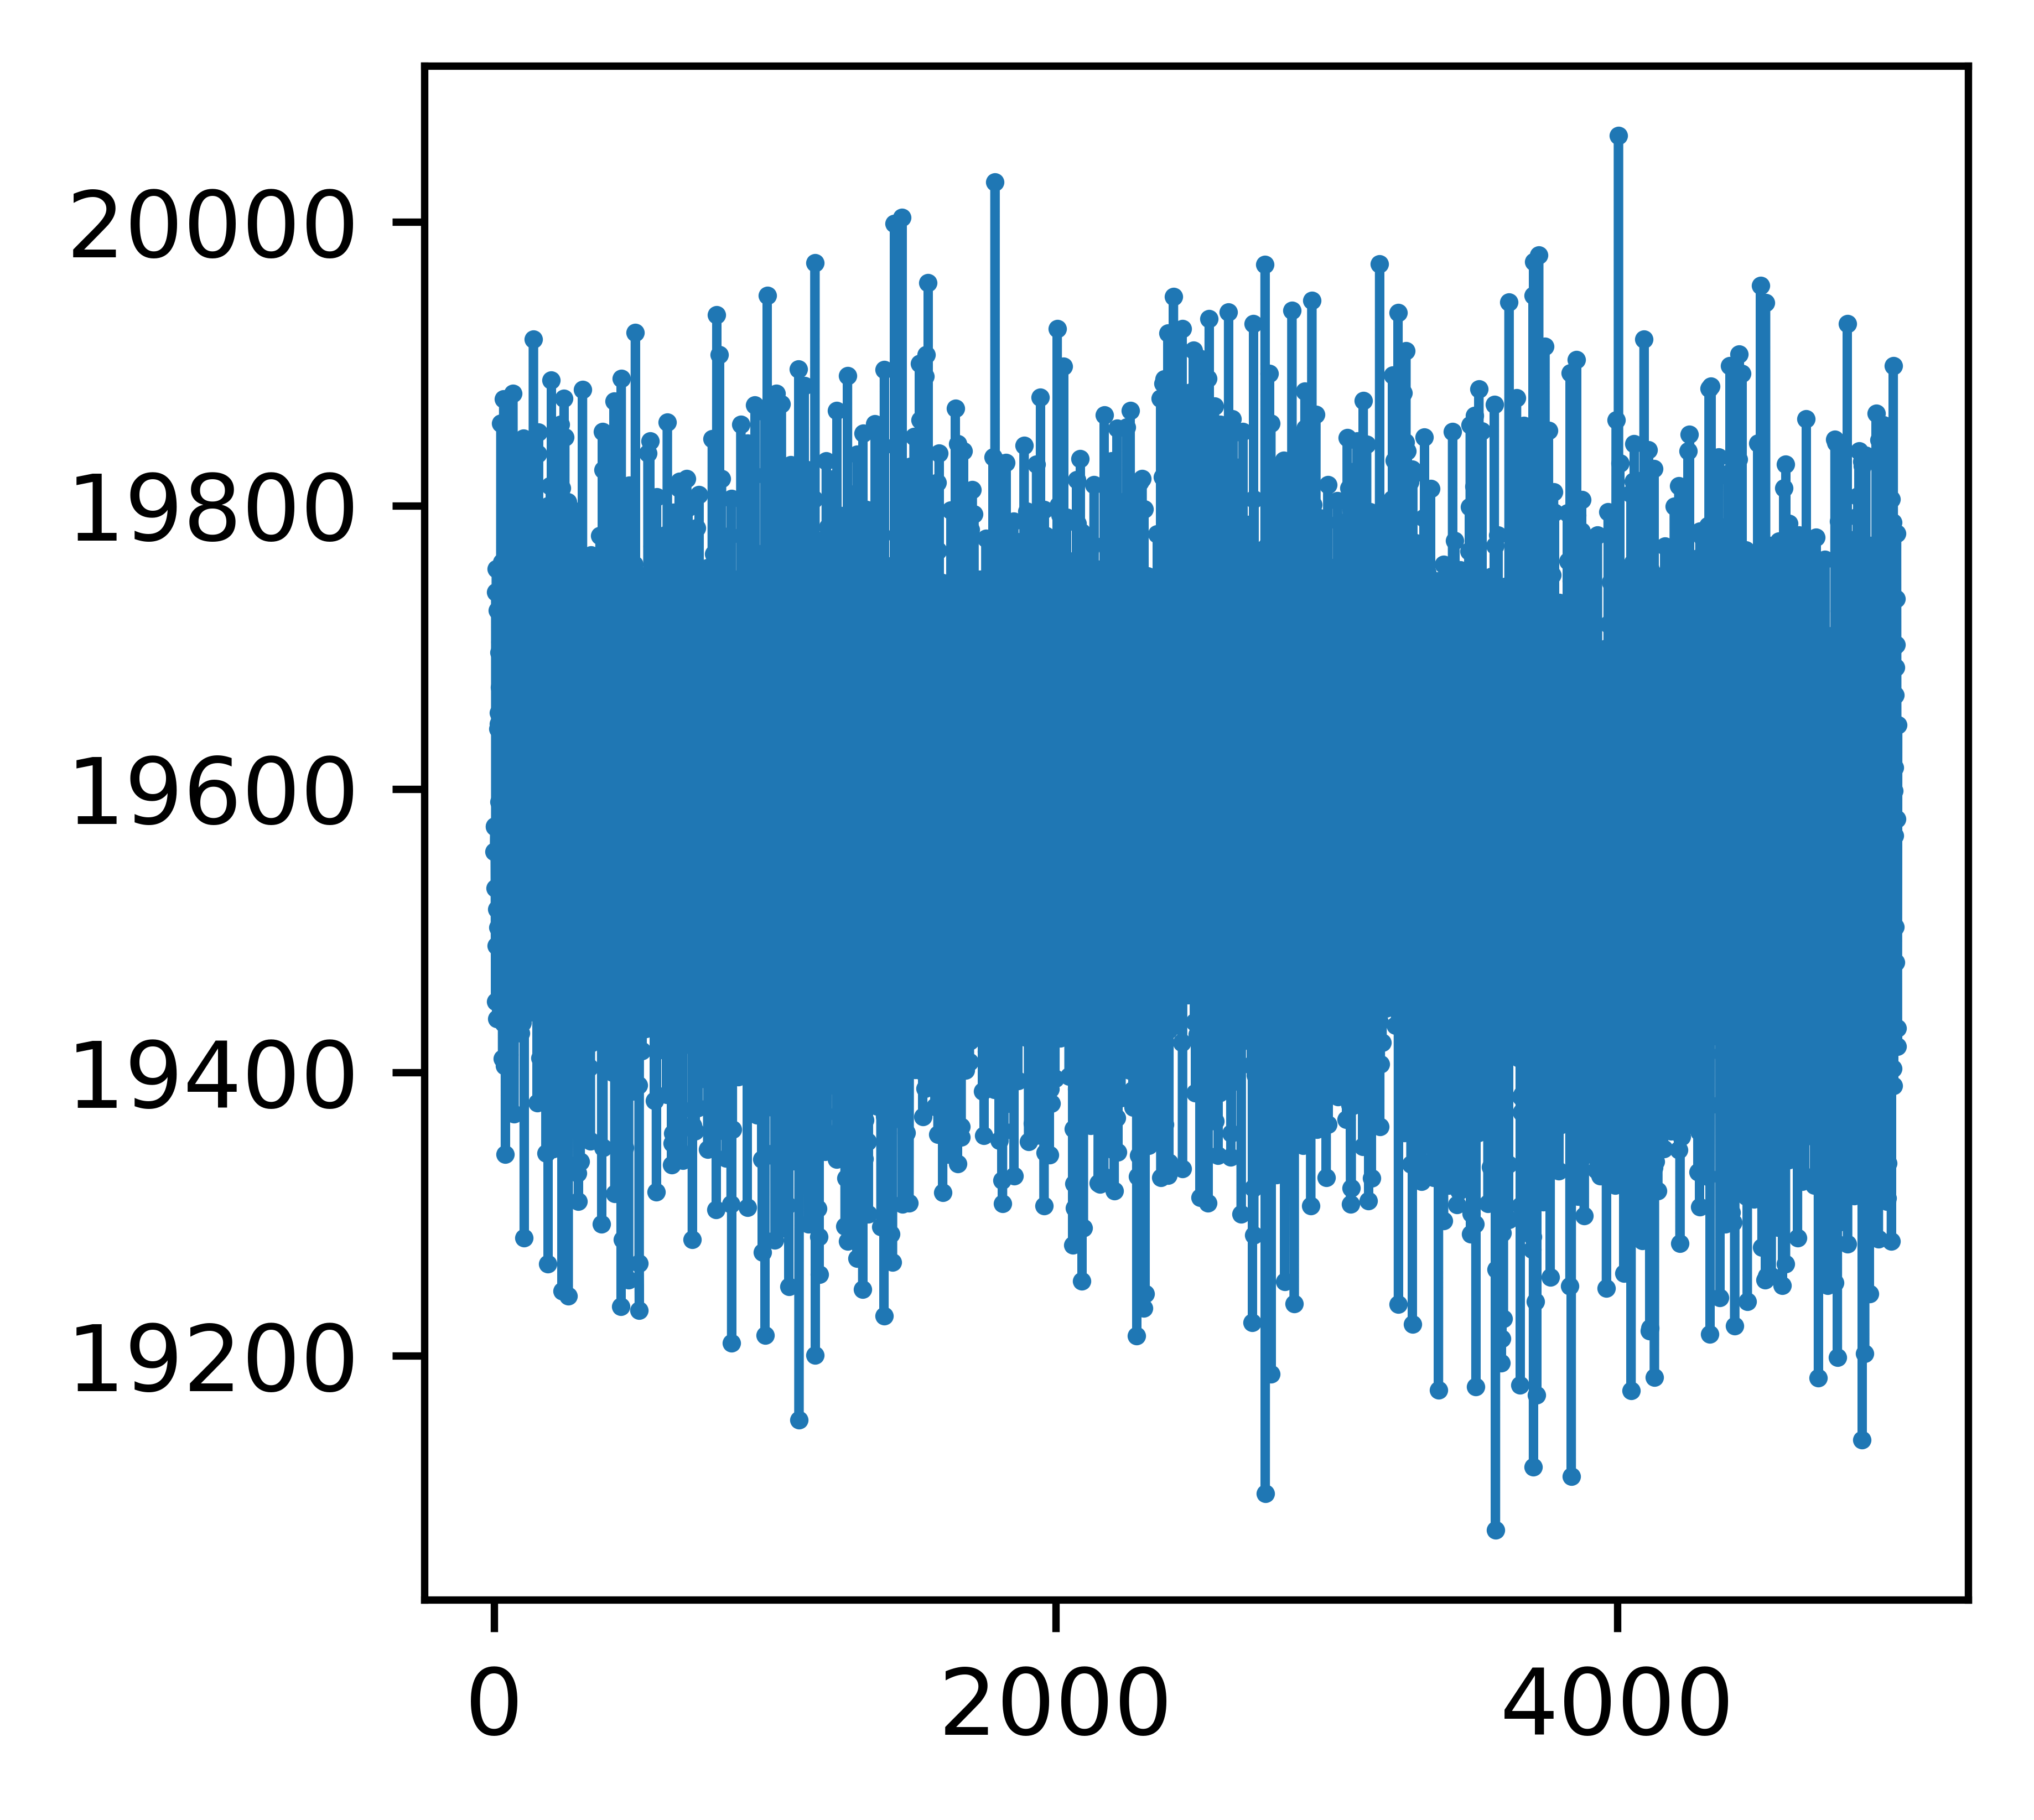

In [26]:
data = np.genfromtxt(job.fn("sim_data.txt"), names=True)
pressure = data["mdcomputeThermodynamicQuantitiespotential_energy"]
plt.plot(pressure[-5000:])

In [15]:
def sample_job(job, threshold_neff=1000, threshold_fraction=0):
    data = np.genfromtxt(job.fn("sim_data.txt"), names=True)
    volume = data["mdcomputeThermodynamicQuantitiesvolume"]
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
            volume[-2000:],
            threshold_fraction=threshold_fraction,
            threshold_neff=threshold_neff
    )
    np.savetxt("pressure_sample_indices.txt", uncorr_indices)
    np.savetxt("pressure.txt", uncorr_sample)
    # Save pressure results in the job doc
    job.doc.volume_start = prod_start
    job.doc.average_volume = np.mean(uncorr_sample)
    job.doc.volume_std = np.std(uncorr_sample)
    job.doc.volume_sem = np.std(uncorr_sample)/(len(uncorr_sample)**0.5)
    # Log potential energy
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
            pe[-2000:],
            threshold_fraction=threshold_fraction,
            threshold_neff=threshold_neff
    )
    np.savetxt("pe_sample_indices.txt", uncorr_indices)
    np.savetxt("potential_energy.txt", uncorr_sample)
    # Save potential energy results in the job doc
    job.doc.pe_start = prod_start
    job.doc.average_pe = np.mean(uncorr_sample)
    job.doc.pe_std = np.std(uncorr_sample)
    job.doc.pe_sem = np.std(uncorr_sample)/(len(uncorr_sample)**0.5)
    # Add a few more things to the job job
    #job.doc.total_steps = job.sp.n_steps + (extra_runs*job.sp.extra_steps)
    #job.doc.total_time = job.doc.total_steps*job.doc.real_timestep
    #job.doc.extra_runs = extra_runs
    job.doc.sampled = True
    job.doc.done = True